In [ ]:
import sys
sys.path.append('..')

In [2]:
import torch
import pickle
import yaml
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from reaction_predictors.graph_model.models import RGCNNTrClassifier
from utils.graph_utils import get_bonds, get_nodes
from utils.torch_dataset import Dataset, graph_collate
from utils.draw_utils import draw_gt_reaction, get_react_prouct, get_molecule_svg, draw_molecule
from reaction_predictors.graph_model.model_utils import train_epoch, evaluate, test
from collections import namedtuple
from sklearn.metrics import confusion_matrix

RDKit WARNING: [18:24:35] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
import pickle
from utils.draw_utils import draw_gt_reaction
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
from rdkit.Chem import rdDepictor
IPythonConsole.molSize = (400,400)

In [4]:
def prune_dataset_by_length(dataset, max_len):
    new_dataset = {}
    for idx in dataset:
        r_mask = dataset[idx]['reactants']['mask']
        r_mask = r_mask[r_mask > 0]
        if len(dataset[idx]['target_main_product']) <= max_len and len(np.unique(r_mask)) == len(r_mask):
            new_dataset[idx] = dataset[idx]
    return new_dataset

In [5]:
def convert(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            dictionary[key] = convert(value)
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

In [6]:
with open('../scripts/graph_models/MT_EGTBF_150.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [7]:
device = 'cuda:0'
model_cfg = convert(config["model"])
data_cfg = convert(config["dataset"])
train_cfg = convert(config["train"])
paths = convert(config["paths"])

In [8]:
meta = pickle.load(open(paths.dataset_path + 'meta.pkl', 'rb'))

node2label = get_nodes(meta['node'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level)
bond2label = get_bonds(meta['type'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level,
                       self_bond=data_cfg.self_bond)

In [9]:
num_rels = len(bond2label)
pad_length = data_cfg.max_num_atoms + 15 * data_cfg.n_molecule_level + \
             data_cfg.n_molecule_level * data_cfg.n_reaction_level
num_nodes = pad_length

In [10]:
model =torch.load(paths.save_path)
model = model.to(device)

In [11]:
test_dataset = pickle.load(open(paths.dataset_path + 'test.pkl', 'rb'))
lengths = []
centers = []

for idx in test_dataset:
    data = test_dataset[idx]
    lengths.append(len(data['target_main_product']))
    cent = data['target_center']
    cent = cent[cent == 1]
    centers.append(len(cent))

In [12]:
test_dataset = prune_dataset_by_length(test_dataset, data_cfg.max_num_atoms)
ts_dataset = Dataset(test_dataset, device=device, pad_length=pad_length,
                         bond2label=bond2label, node2label=node2label, feature_idxs=data_cfg.feature_idxs,
                         target_main_product=data_cfg.target_main_product, target_center=data_cfg.target_center,
                         n_molecule_level=data_cfg.n_molecule_level, n_reaction_level=data_cfg.n_reaction_level)
test_loader = DataLoader(ts_dataset, train_cfg.batch_size, drop_last=True, collate_fn=graph_collate)

In [13]:
predictions = test(model, test_loader, drop_pad=False)

In [14]:
evaluate(model, test_loader, names=['MP', 'Detection of cenetr of reaction'])
pass

MP was done with 0.9877930074036405 F1-measure and 0.7374079651941098 full-match accuracy


/home/phillnik/.conda/envs/chem/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Detection of cenetr of reaction was done with 0.8815925293788419 F1-measure and 0.6610818273092369 full-match accuracy


In [15]:
idxs = list(test_dataset.keys())[:len(predictions[0]['target'])]

In [16]:
c_fma = {}
mp_fma = {}

In [17]:
c_centers = {}
c_lengths = {}
mp_centers = {}
mp_lengths = {}
n_smooth = 10
for mpt, mpp, ct, cp in zip(predictions[0]['target'], predictions[0]['predicted'], predictions[1]['target'], predictions[1]['predicted']):
    mpp = mpp[mpt != -1]
    mpt = mpt[mpt != -1]
    cp = cp[ct != -1]
    ct = ct[ct != -1]
    idx = len(mpt)//n_smooth
    if idx not in mp_lengths:
        mp_lengths[idx] = []
        c_lengths[idx] = []
    mp_lengths[idx].append((mpt == mpp).min())
    c_lengths[idx].append((ct == cp).min())
    n_c = int(ct.sum())
    if n_c not in mp_centers:
        mp_centers[n_c] = []
        c_centers[n_c] = []
    mp_centers[n_c].append((mpt == mpp).min())
    c_centers[n_c].append((ct == cp).min())
    
    if (idx, n_c) not in  c_fma:
        c_fma[(idx, n_c)] = []
        mp_fma[(idx, n_c)] = []
    
    c_fma[(idx, n_c)].append((ct == cp).min())
    mp_fma[(idx, n_c)].append((mpt == mpp).min())

In [18]:
del mp_lengths[15]
del c_lengths[15]

In [19]:
len_count = {}
cent_count = {}

In [20]:
for mpc, cc in zip(mp_centers, c_centers):
    cent_count[cc] = len(c_centers[cc])
    mp_centers[mpc] = np.mean(mp_centers[mpc])
    c_centers[cc] = np.mean(c_centers[cc])

In [21]:
for mpc, cc in zip(mp_lengths, c_lengths):
    len_count[mpc] = len(mp_lengths[mpc])
    mp_lengths[mpc] = np.mean(mp_lengths[mpc])
    c_lengths[cc] = np.mean(c_lengths[cc])

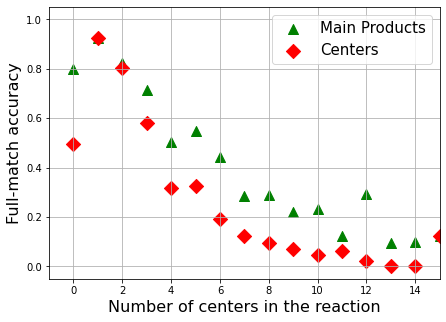

In [22]:
plt.figure(figsize=(7, 5))
plt.scatter(list(mp_centers.keys()), list(mp_centers.values()), label='Main Products', marker='^', s=100, c='g')
plt.scatter(list(c_centers.keys()), list(c_centers.values()), label='Centers', marker='D', s=100, c='r')
plt.xlim(-1, 15)
plt.legend(fontsize=15)
plt.xlabel('Number of centers in the reaction', fontsize=16)
plt.ylabel('Full-match accuracy', fontsize=16)
plt.grid()
plt.savefig('center_quality.png', dpi=300)
plt.show()

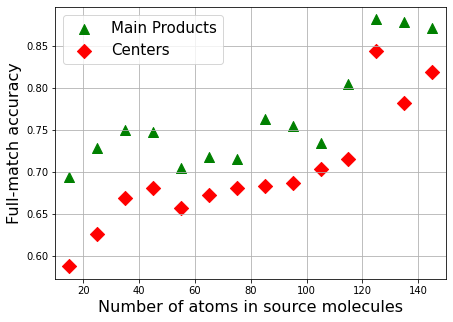

In [23]:
plt.figure(figsize=(7, 5))
plt.scatter(np.array(list(mp_lengths.keys()))*n_smooth + n_smooth//2, list(mp_lengths.values()), label='Main Products', marker='^', s=100, c='g')
plt.scatter(np.array(list(c_lengths.keys()))*n_smooth + n_smooth//2, list(c_lengths.values()), label='Centers', marker='D', s=100, c='r')
plt.xlim(10, 150)
plt.legend(fontsize=15)
plt.ylabel('Full-match accuracy', fontsize=16)
plt.xlabel('Number of atoms in source molecules', fontsize=16)
plt.grid()
plt.savefig('len_quality.png', dpi=300)
plt.show()

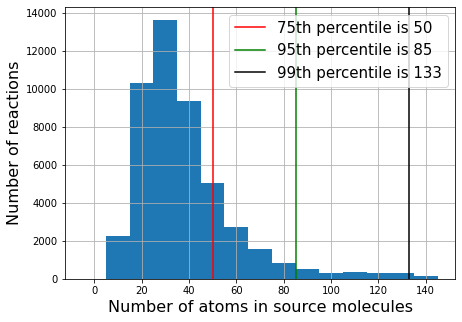

In [24]:
plt.figure(figsize=(7, 5))
plt.bar(np.array(list(len_count.keys()))*n_smooth, list(len_count.values()), align='center', width = 10)
percentiles = [np.percentile(lengths, 75), np.percentile(lengths, 95), np.percentile(lengths, 99)]
plt.axvline(x=percentiles[0], c='r', label=f'{75}th percentile is {int(percentiles[0])}')
plt.axvline(x=percentiles[1], c='g', label=f'{95}th percentile is {int(percentiles[1])}')
plt.axvline(x=percentiles[2], c='black', label=f'{99}th percentile is {int(percentiles[2])}')
plt.legend(fontsize=15)
plt.xlabel('Number of atoms in source molecules', fontsize=16)
plt.ylabel('Number of reactions', fontsize=16)
plt.grid()
plt.savefig('len_dist.png', dpi=300)
plt.show()

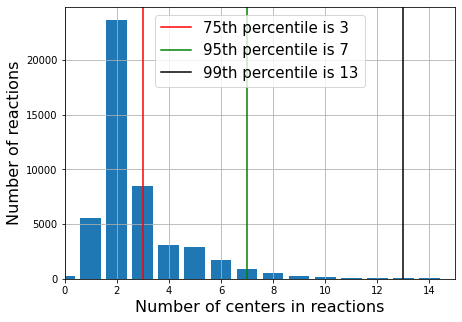

In [25]:
plt.figure(figsize=(7, 5))
plt.bar(list(cent_count.keys()), list(cent_count.values()), align='center', width = 0.8)
percentiles = [np.percentile(centers, 75), np.percentile(centers, 95), np.percentile(centers, 99)]
plt.axvline(x=percentiles[0], c='r', label=f'{75}th percentile is {int(percentiles[0])}')
plt.axvline(x=percentiles[1], c='g', label=f'{95}th percentile is {int(percentiles[1])}')
plt.axvline(x=percentiles[2], c='black', label=f'{99}th percentile is {int(percentiles[2])}')
plt.xlim(0, 15)
plt.legend(fontsize=15)
plt.grid()
plt.xlabel('Number of centers in reactions', fontsize=16)
plt.ylabel('Number of reactions', fontsize=16)
plt.savefig('cent_dist.png', dpi=300)
plt.show()

In [26]:
len_groups = (np.array(lengths) - 1) // 10
cm = confusion_matrix(centers, len_groups)

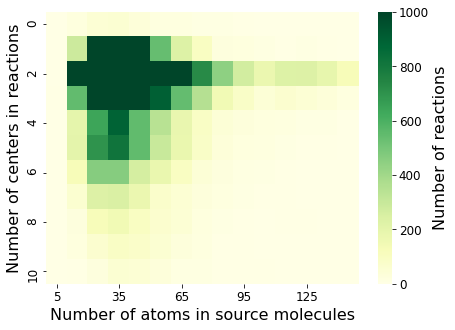

In [27]:
plt.figure(figsize=(7, 5))
xt = (np.arange(15)*10 + 5)
yt = np.arange(11)
df = pd.DataFrame(cm[:11, :15], columns=xt, index=yt)
sn.heatmap(df, xticklabels=3, yticklabels=2, cmap='YlGn', robust=True, center=500, vmax=1000, 
           cbar_kws={'label': 'Number of reactions'})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=12)
cax.yaxis.label.set_size(16)

plt.xlabel('Number of atoms in source molecules', fontsize=16)
plt.ylabel('Number of centers in reactions', fontsize=16)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.savefig('len_cm.png', dpi=300)
plt.show()

In [28]:
c_cm = np.zeros((11, 15))
for idx in c_fma:
    if idx[0] < 15 and idx[1] < 11:
        c_cm[idx[1], idx[0]] = np.mean(c_fma[idx])
c_cm = np.around(c_cm*100, decimals=0)

In [29]:
mp_cm = np.zeros((11, 15))
for idx in mp_fma:
    if idx[0] < 15 and idx[1] < 11:
        mp_cm[idx[1], idx[0]] = np.mean(mp_fma[idx])
mp_cm = np.around(mp_cm*100)

In [30]:
import pandas as pd

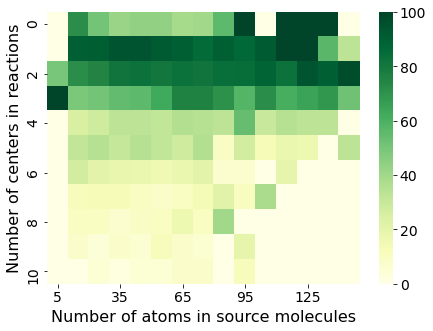

In [31]:
plt.figure(figsize=(7, 5))
xt = (np.arange(15)*10 + 5)
yt = np.arange(11)
df = pd.DataFrame(c_cm, columns=xt, index=yt)
sn.heatmap(df, xticklabels=3, yticklabels=2, cmap='YlGn', robust=True)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)
plt.xlabel('Number of atoms in source molecules', fontsize=16)
plt.ylabel('Number of centers in reactions', fontsize=16)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#plt.savefig('c_qual_cm.png', dpi=300)
plt.show()

In [32]:
c_cm[c_cm == 100] = 99

In [33]:
from matplotlib.colors import LogNorm

In [37]:
df.max()

5         4
15     1402
25     5457
35     6694
45     4341
55     2205
65     1141
75      729
85      449
95      272
105     178
115     233
125     238
135     192
145     125
dtype: int64

In [40]:
norm=LogNorm(1, 6694)

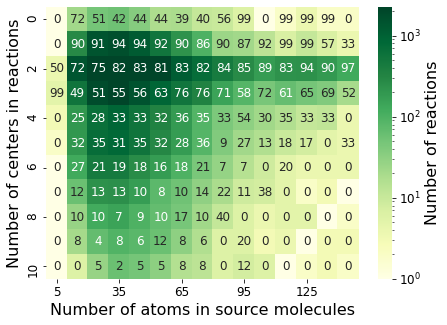

In [53]:
plt.figure(figsize=(7, 5))
xt = (np.arange(15)*10 + 5)
yt = np.arange(11)
df = pd.DataFrame(cm[:11, :15], columns=xt, index=yt)
sn.heatmap(df+1, xticklabels=3, yticklabels=2, cmap='YlGn', robust=True, 
           annot=c_cm, annot_kws={"size": 12}, cbar_kws={'label': 'Number of reactions'}, 
          norm=LogNorm(1, 6694))
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=12)
cax.yaxis.label.set_size(16)

plt.xlabel('Number of atoms in source molecules', fontsize=16)
plt.ylabel('Number of centers in reactions', fontsize=16)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.savefig('../imgs/c_len_cm.png', dpi=300)
plt.show()

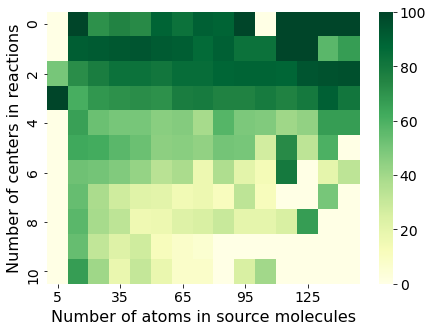

In [54]:
plt.figure(figsize=(7, 5))
xt = (np.arange(15)*10 + 5)
yt = np.arange(11)
df = pd.DataFrame(mp_cm, columns=xt, index=yt)
sn.heatmap(df, xticklabels=3, yticklabels=2, cmap='YlGn', robust=True)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)
plt.xlabel('Number of atoms in source molecules', fontsize=16)
plt.ylabel('Number of centers in reactions', fontsize=16)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#plt.savefig('len_cm.png', dpi=300)
plt.show()

In [55]:
mp_cm[mp_cm == 100] = 99

In [56]:
plt.figure(figsize=(7, 5))
xt = (np.arange(15)*10 + 5)
yt = np.arange(11)
df = pd.DataFrame(cm[:11, :15], columns=xt, index=yt)
sn.heatmap(df, xticklabels=3, yticklabels=2, cmap='YlGn', robust=True, annot=mp_cm,
           cbar_kws={'label': 'Number of reactions'}, 
          norm=LogNorm(1, 6694))
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)
cax.tick_params(labelsize=12)
cax.yaxis.label.set_size(16)

plt.xlabel('Number of atoms in source molecules', fontsize=16)
plt.ylabel('Number of centers in reactions', fontsize=16)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.savefig('../imgs/mp_len_cm.png', dpi=300)
plt.show()

ValueError: minvalue must be positive

ValueError: minvalue must be positive

<Figure size 504x360 with 2 Axes>

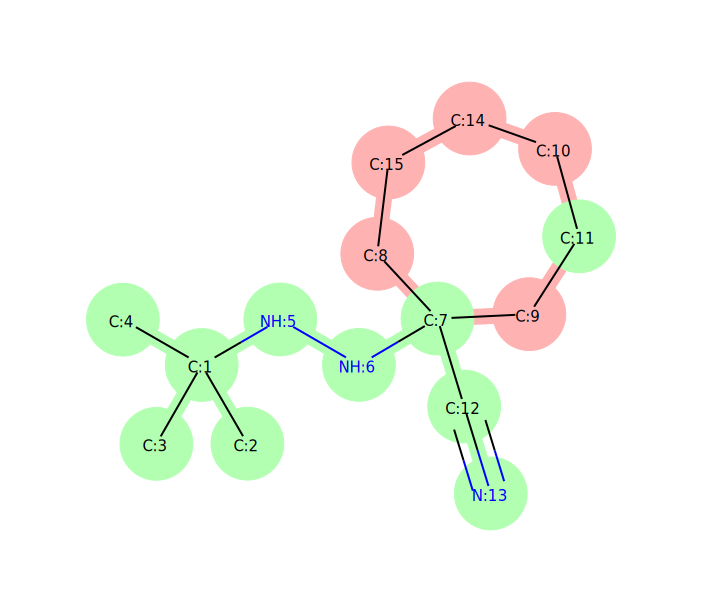

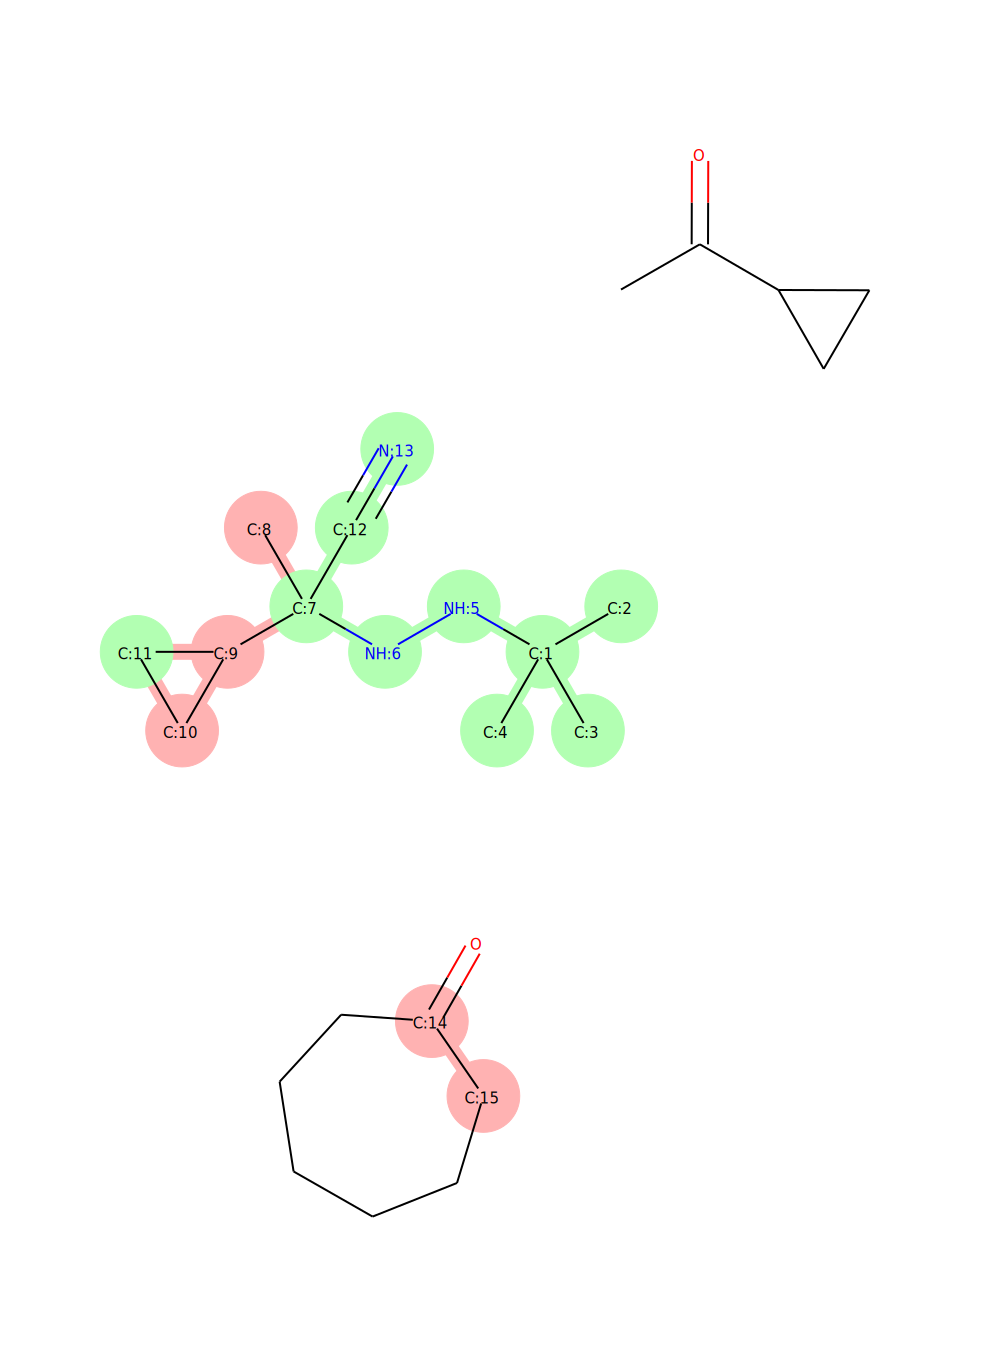

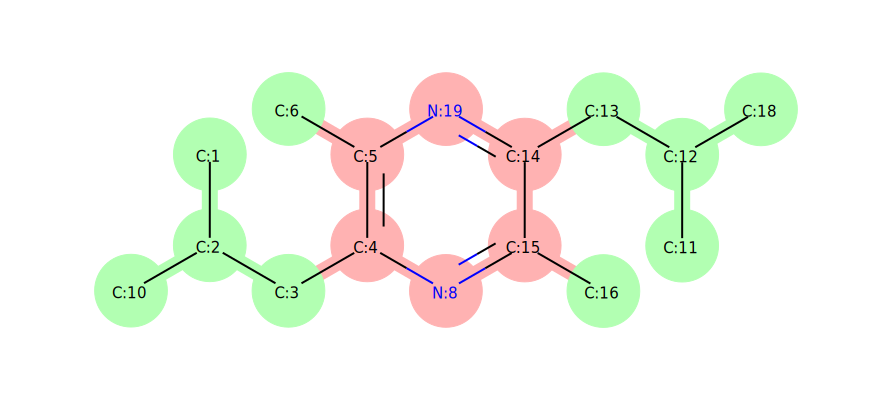

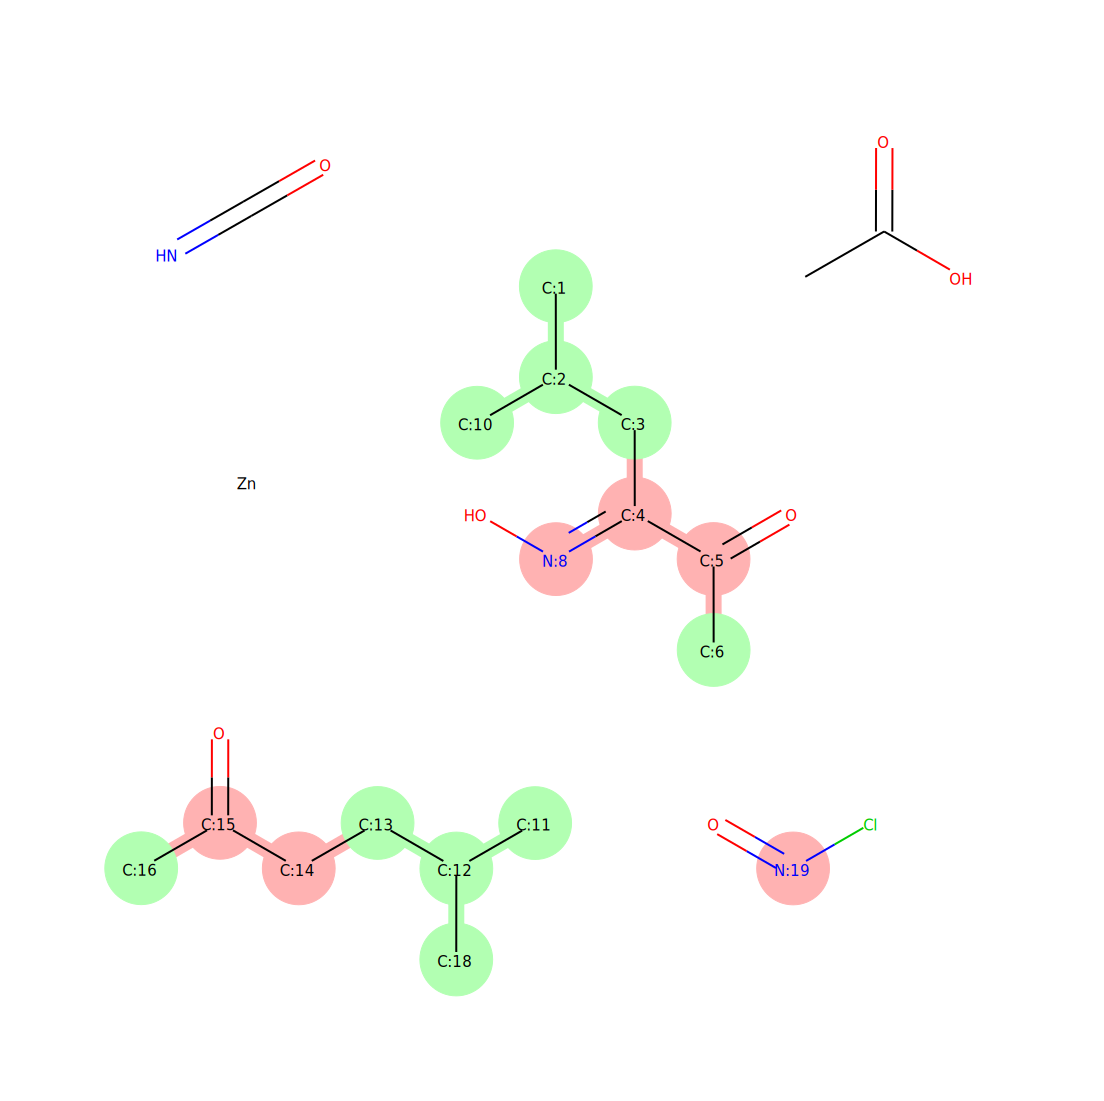

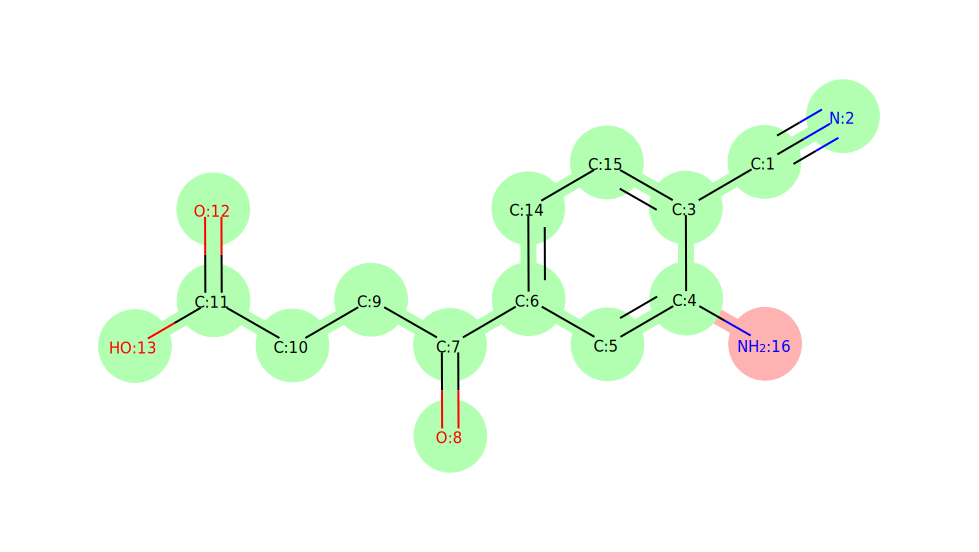

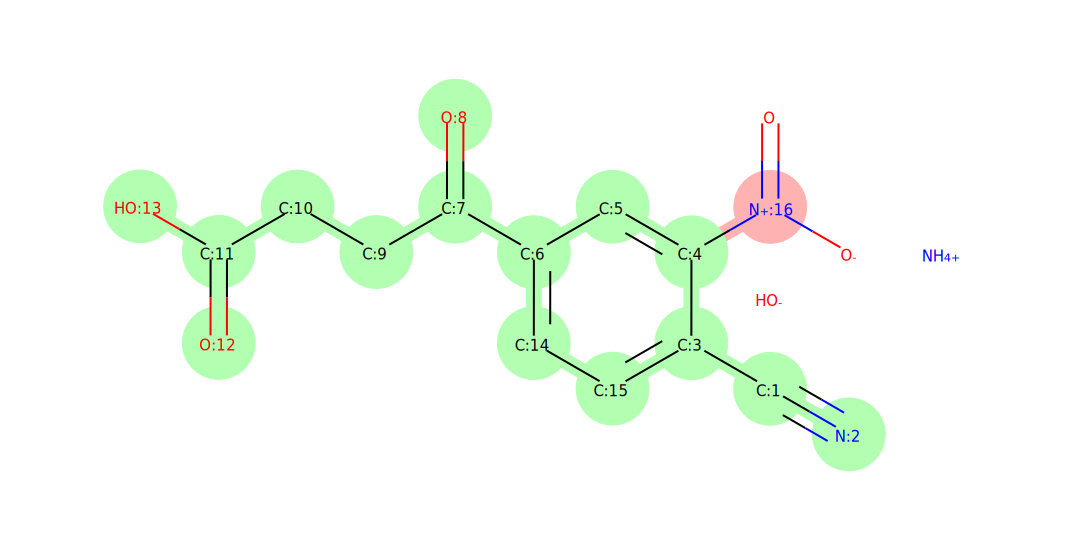

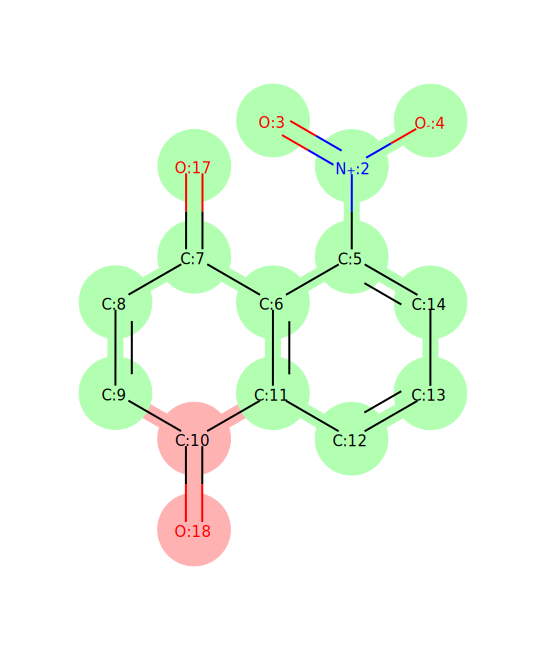

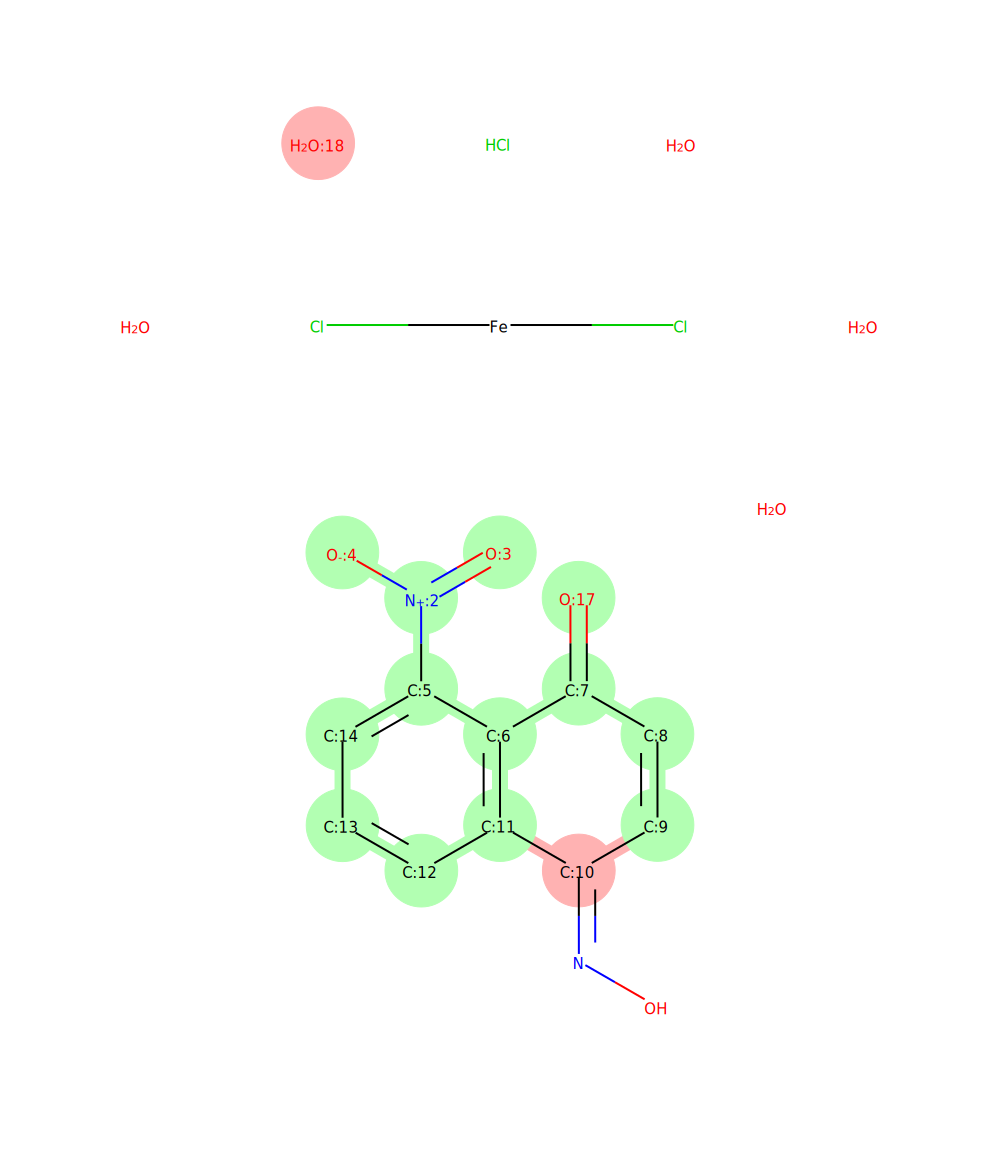

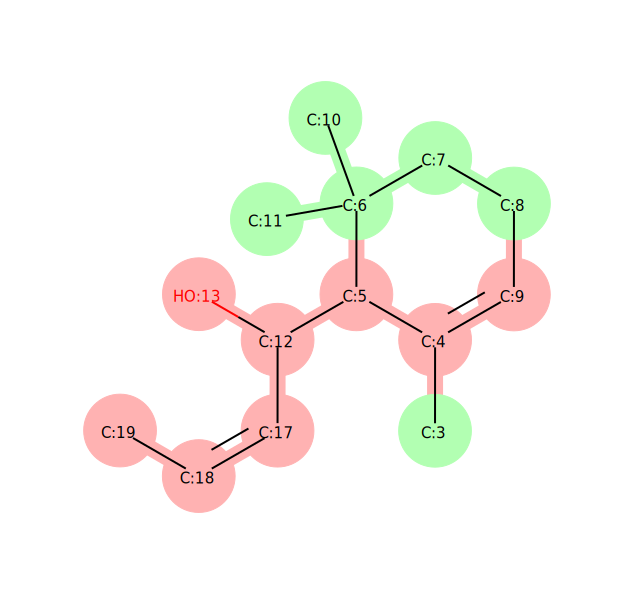

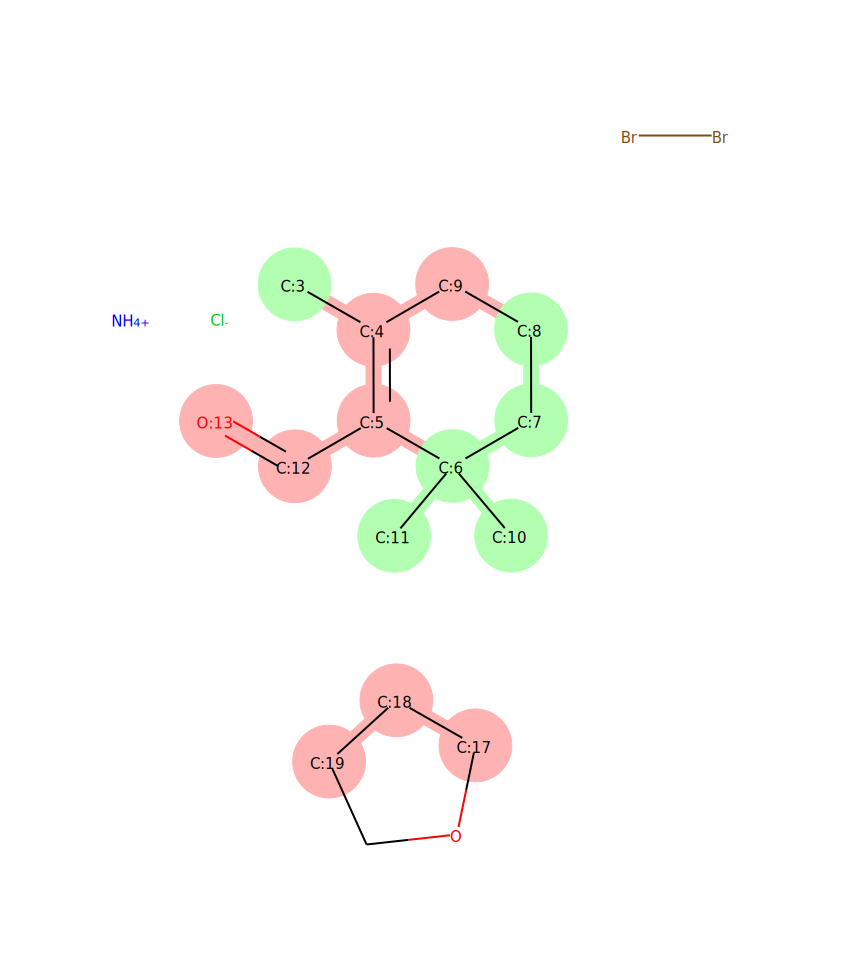

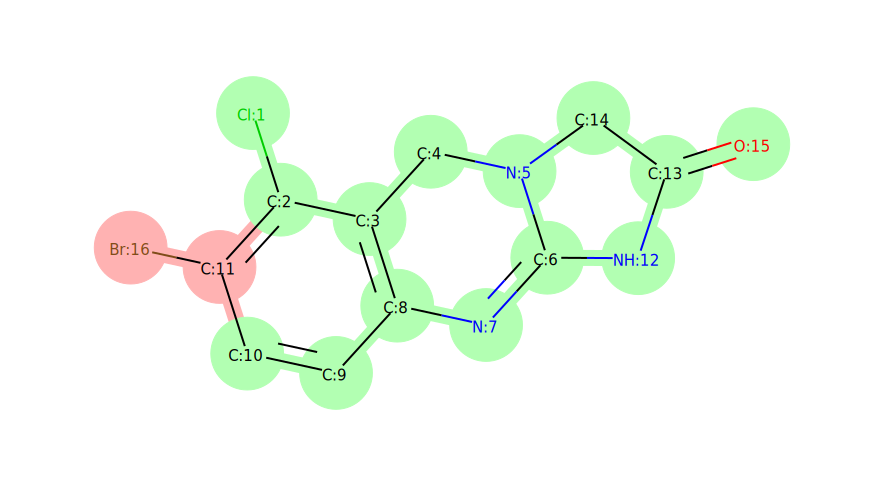

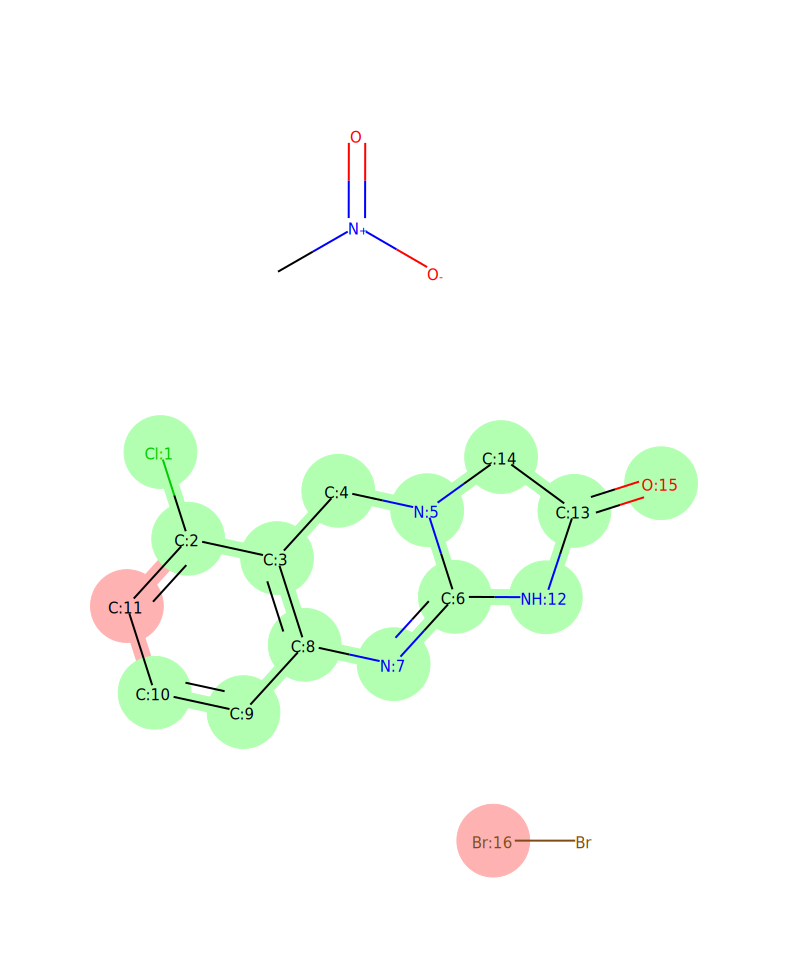

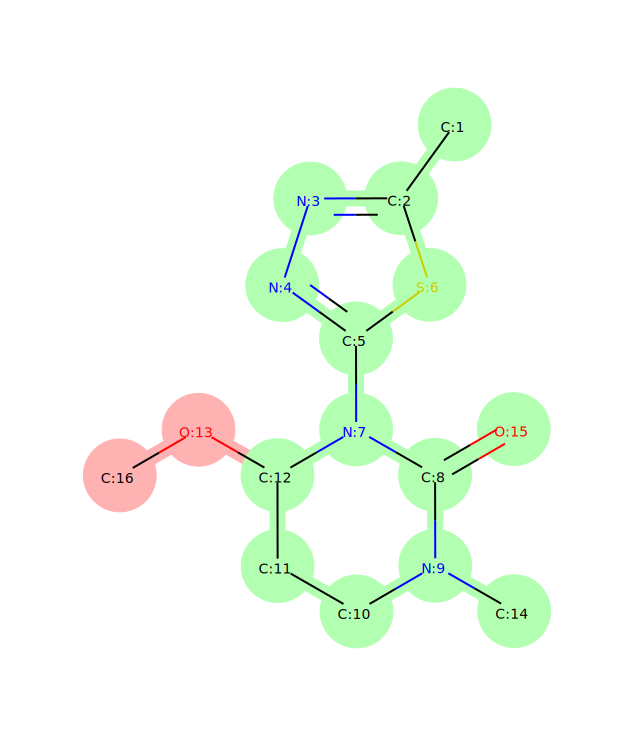

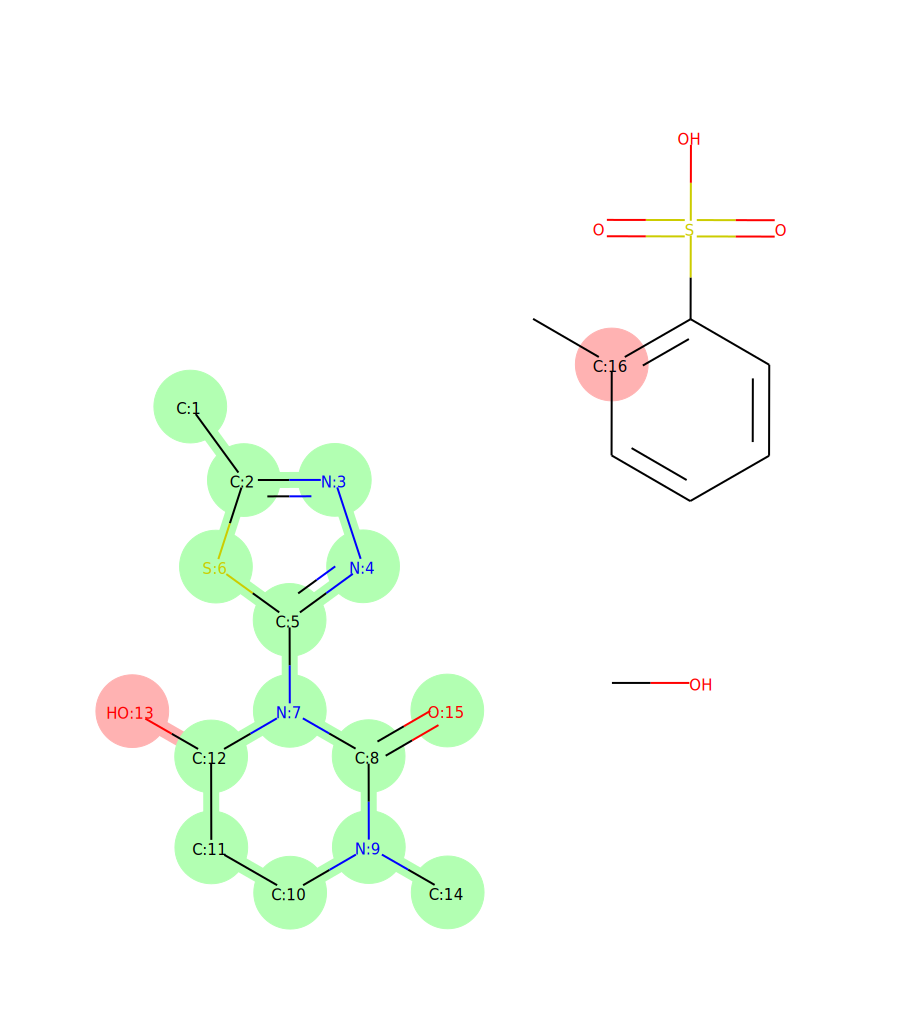

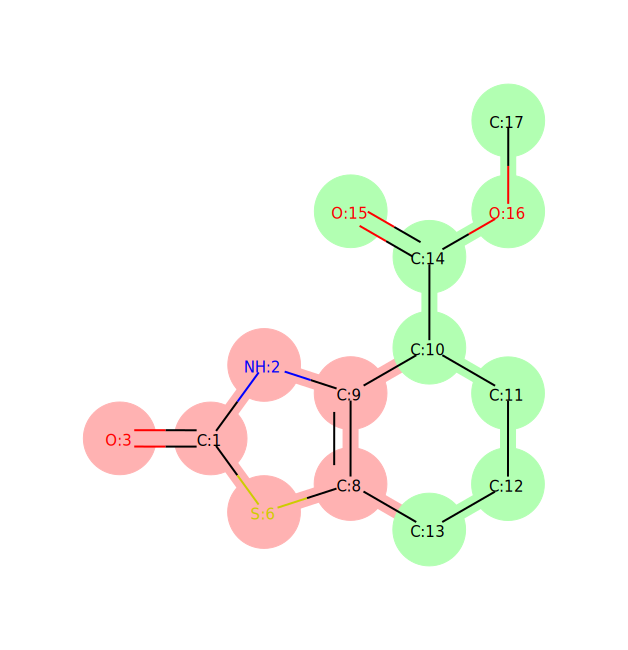

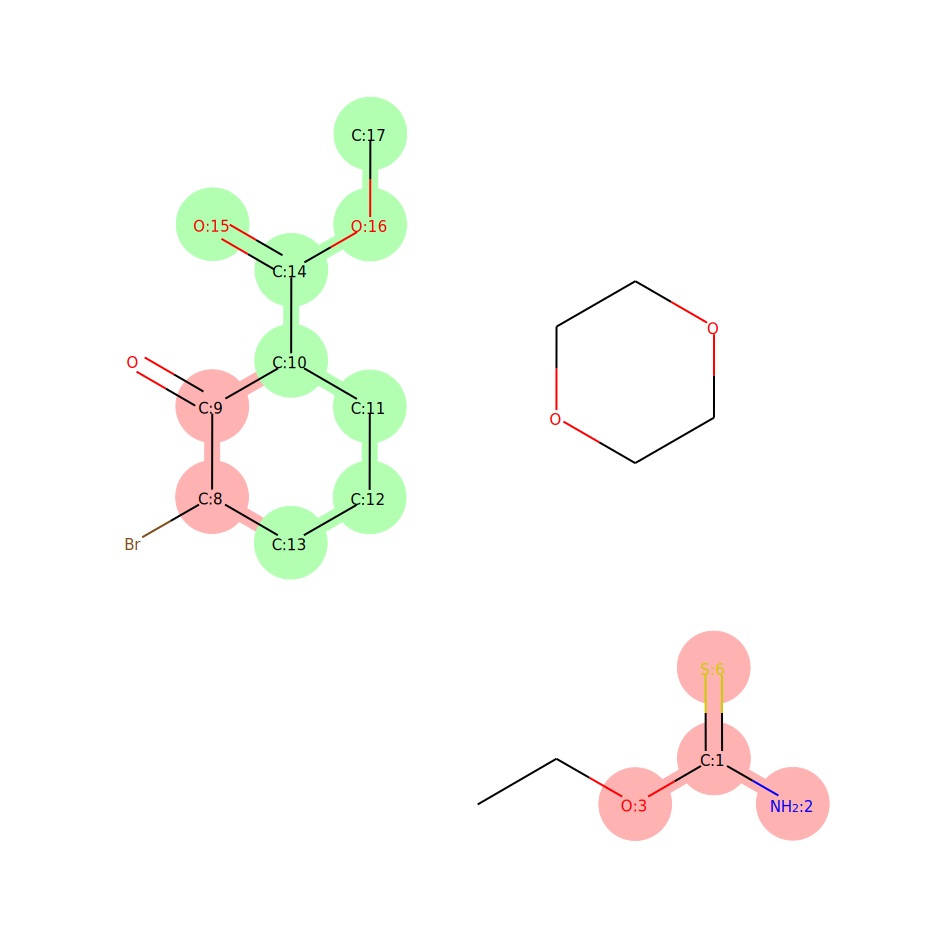

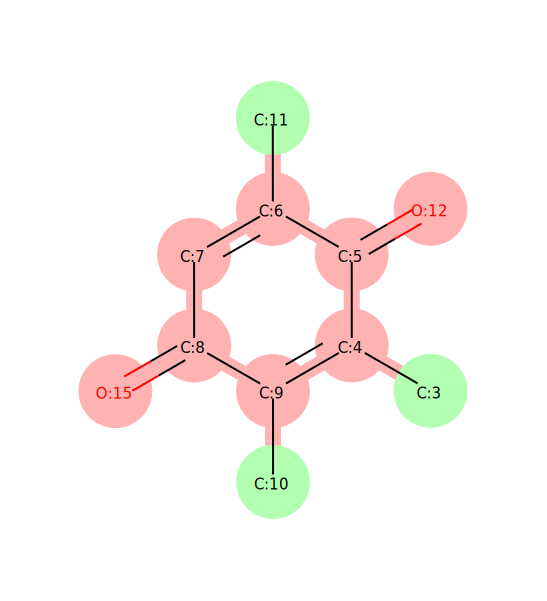

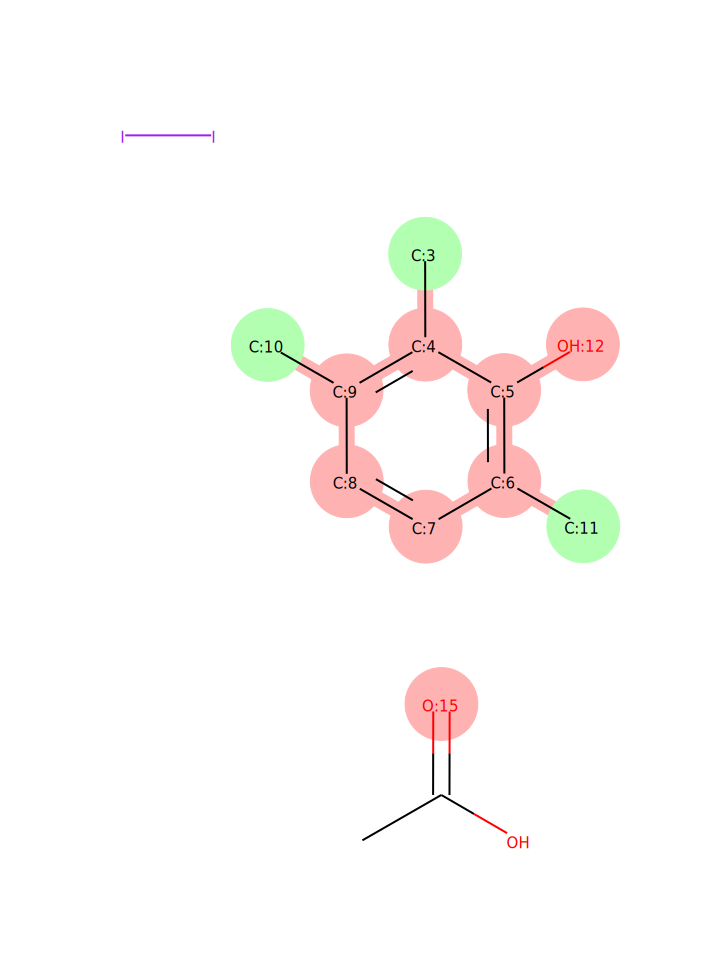

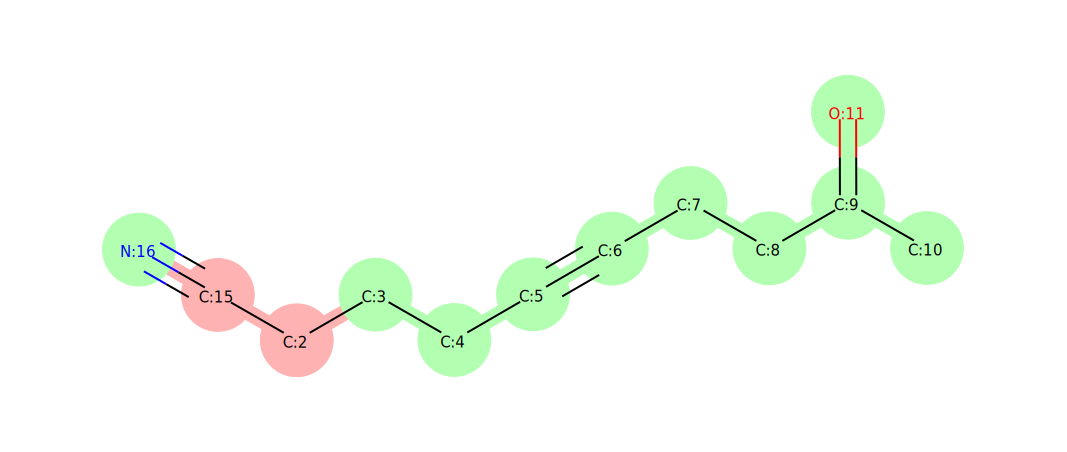

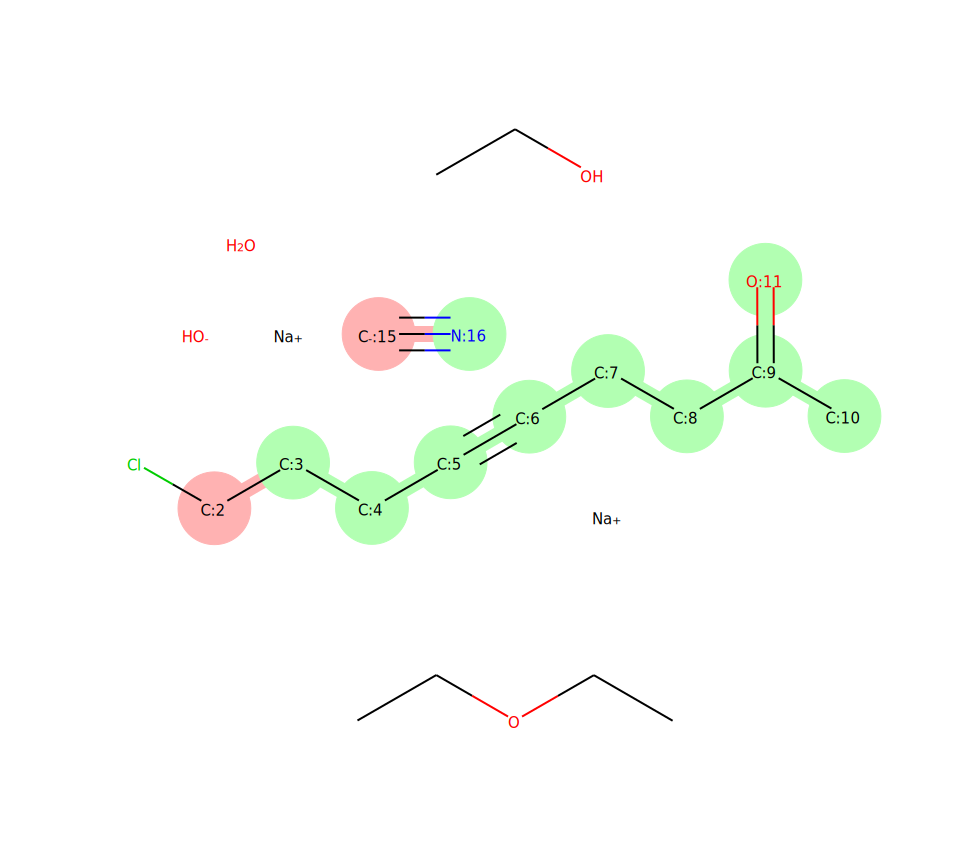

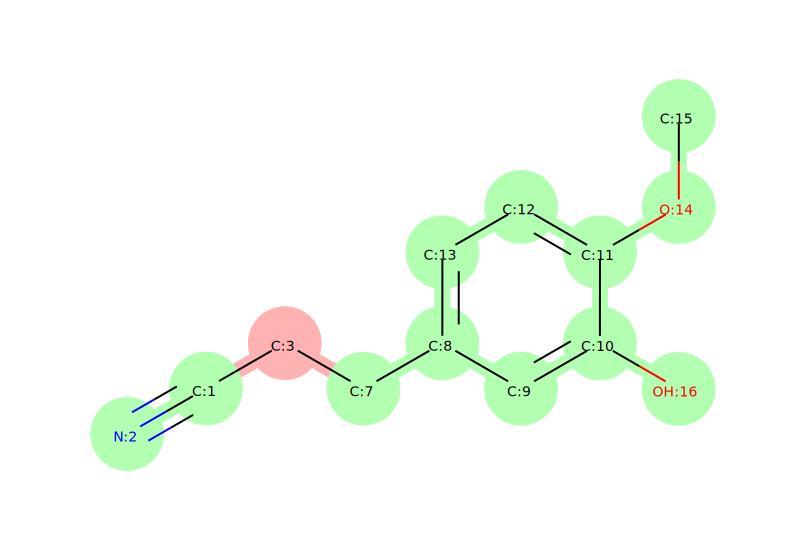

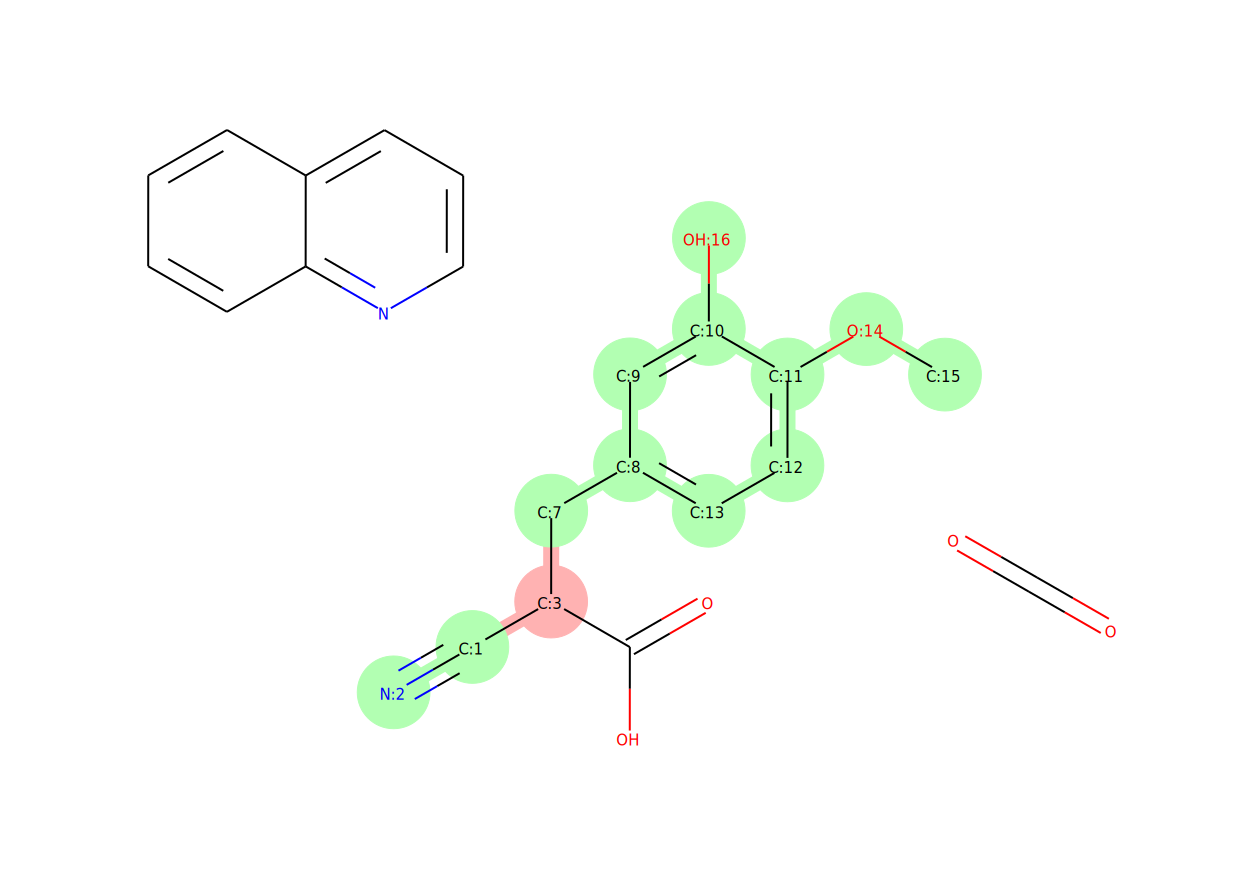

In [31]:
n = 0 
for i, idx in enumerate(idxs):
    data = test_dataset[idx]
    tar = predictions[0]['target'][i]
    pred = predictions[0]['predicted'][i]
    pred = pred[tar != -1]
    tar = tar[tar != -1]
    if len(data["target_main_product"]) < 30 and np.any(tar != pred):
        p, r = draw_gt_reaction(data, mapping=True)
        display(SVG(p))
        display(SVG(r))
        if n < 10:
            n += 1 
        else: 
            break

[OH:1][C@H:2]1[CH2:19][CH2:18][C@@:17]2([CH3:20])[C:4]([CH2:5][CH2:6][C@@H:7]3[C@@H:16]2[C:15](=[O:21])[CH2:14][C@@:12]2([CH3:13])[C@H:8]3[CH2:9][CH2:10][C@@H:11]2[C:22]([O:24][CH3:25])=[O:23])=[CH:3]1.C([O-])(=O)C>CC(C)=O>[OH:1][C@@H:2]1[CH2:19][CH2:18][C@@:17]2([CH3:20])[C:4]([CH2:5][CH2:6][C@@H:7]3[C@@H:16]2[C:15](=[O:21])[CH2:14][C@@:12]2([CH3:13])[C@H:8]3[CH2:9][CH2:10][C@@H:11]2[C:22]([O:24][CH3:25])=[O:23])=[CH:3]1


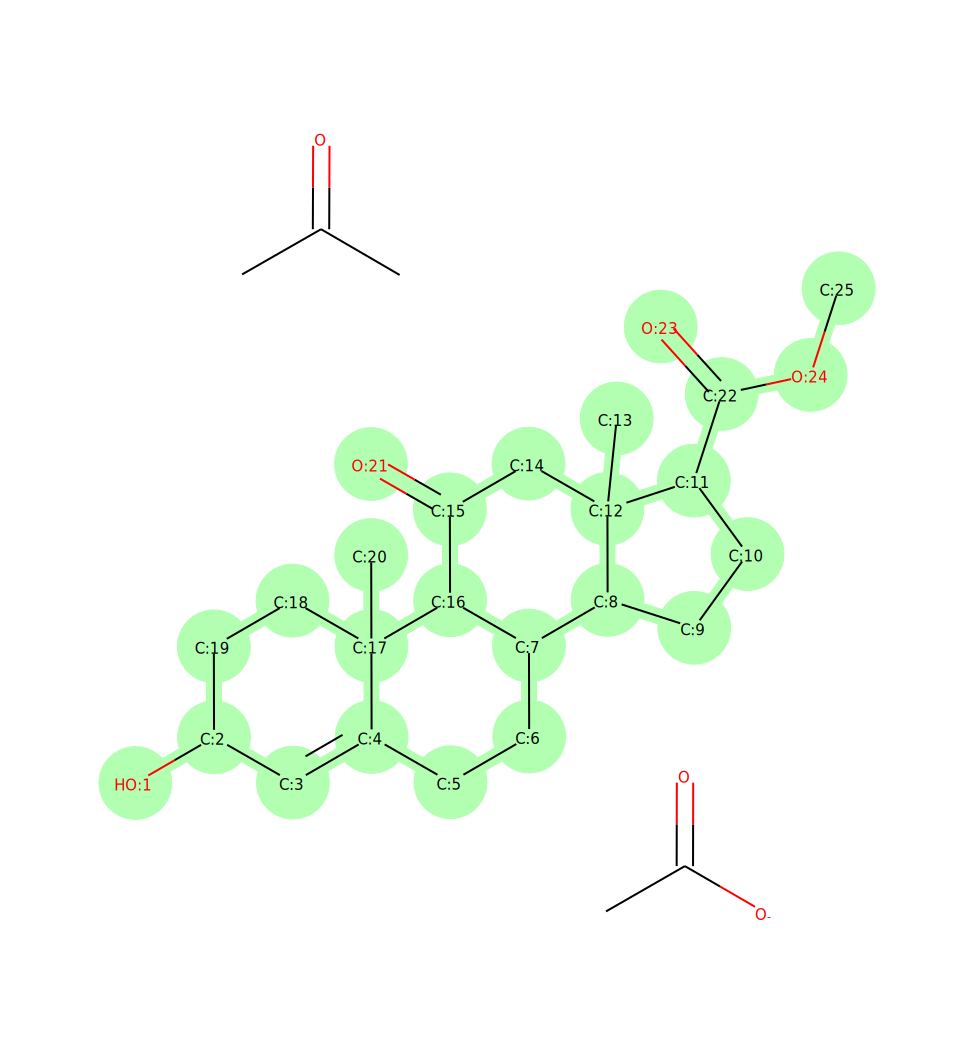

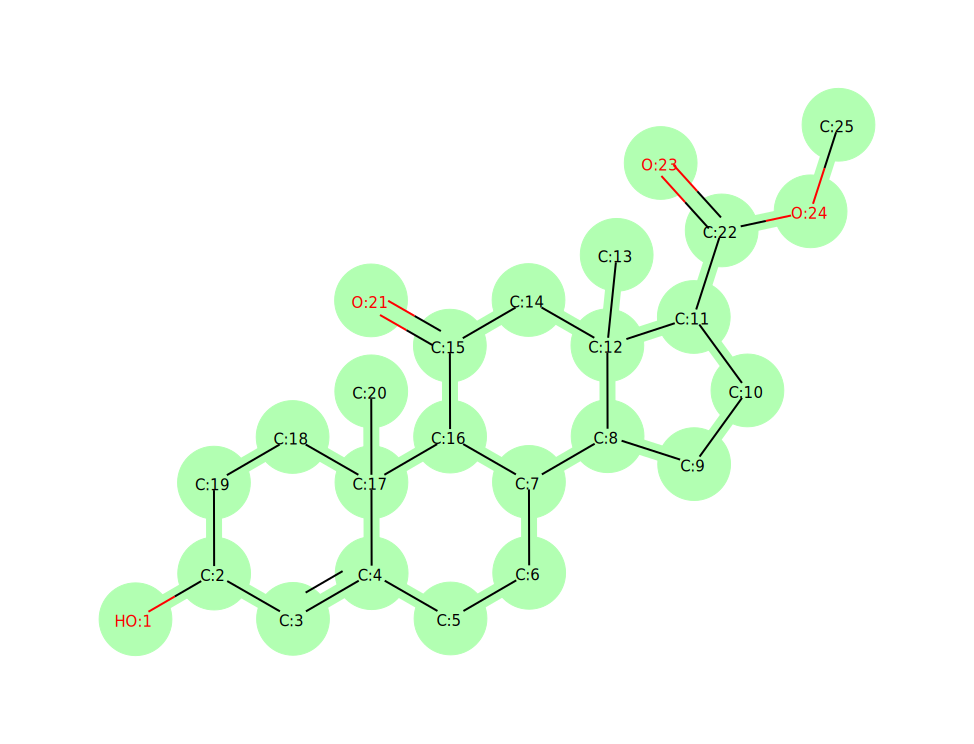

C(O)(=O)CCCCCCC.[N:11]([CH2:18][CH2:19][OH:20])([CH2:15][CH2:16][OH:17])[CH2:12][CH2:13][OH:14]>O>[N:11]([CH2:18][CH2:19][OH:20])([CH2:15][CH2:16][OH:17])[CH2:12][CH2:13][OH:14] 


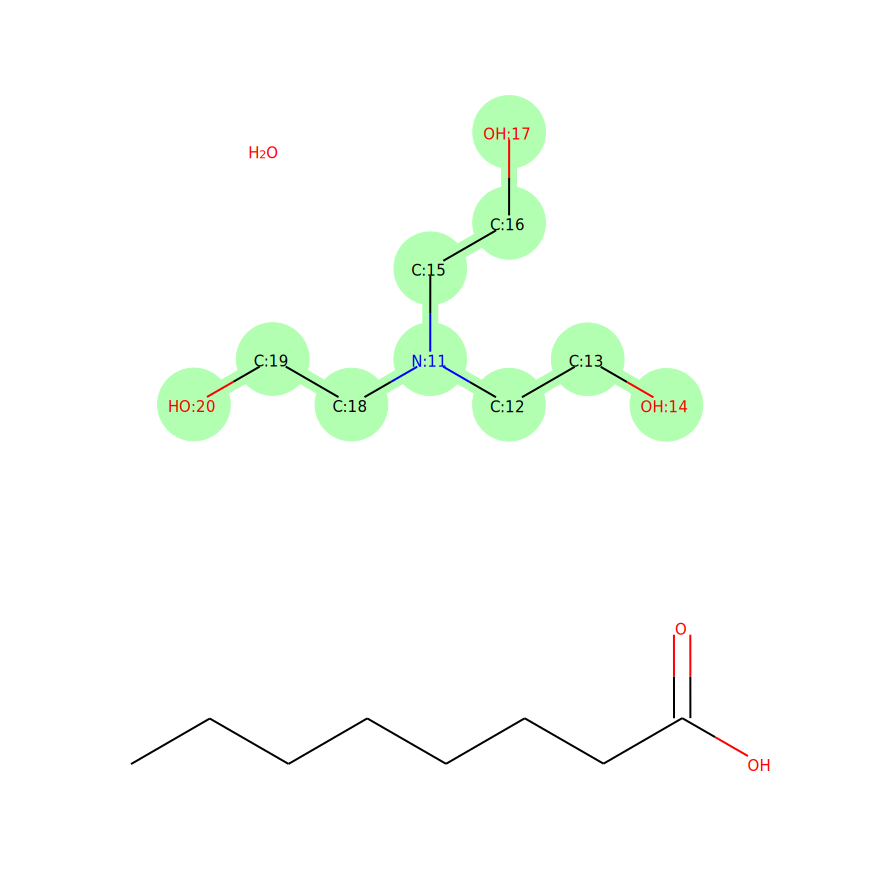

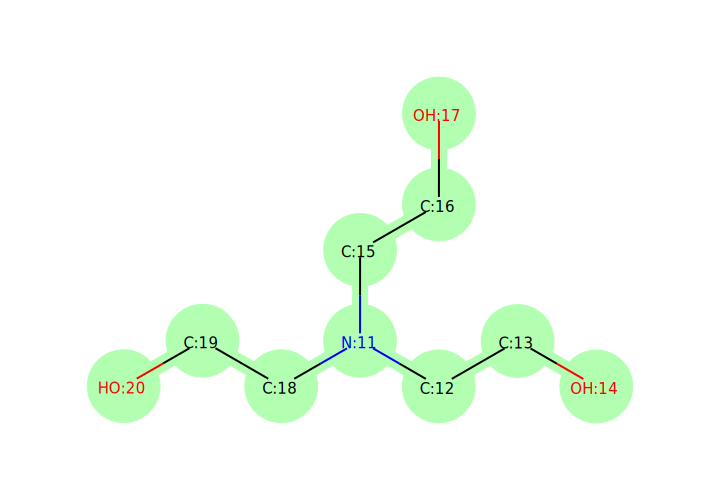

S(O)(O)(=O)=O.[CH3:6][N:7]1[C:16](=[O:17])[CH:15]=[C:14]2[C:9]([CH:10]=[CH:11][CH:12]=[CH:13]2)=[CH:8]1.O.C(=O)(O)[O-].[Na+]>C(Cl)(Cl)Cl>[CH3:6][N:7]1[C:16](=[O:17])[CH:15]=[C:14]2[C:9]([CH:10]=[CH:11][CH:12]=[CH:13]2)=[CH:8]1 


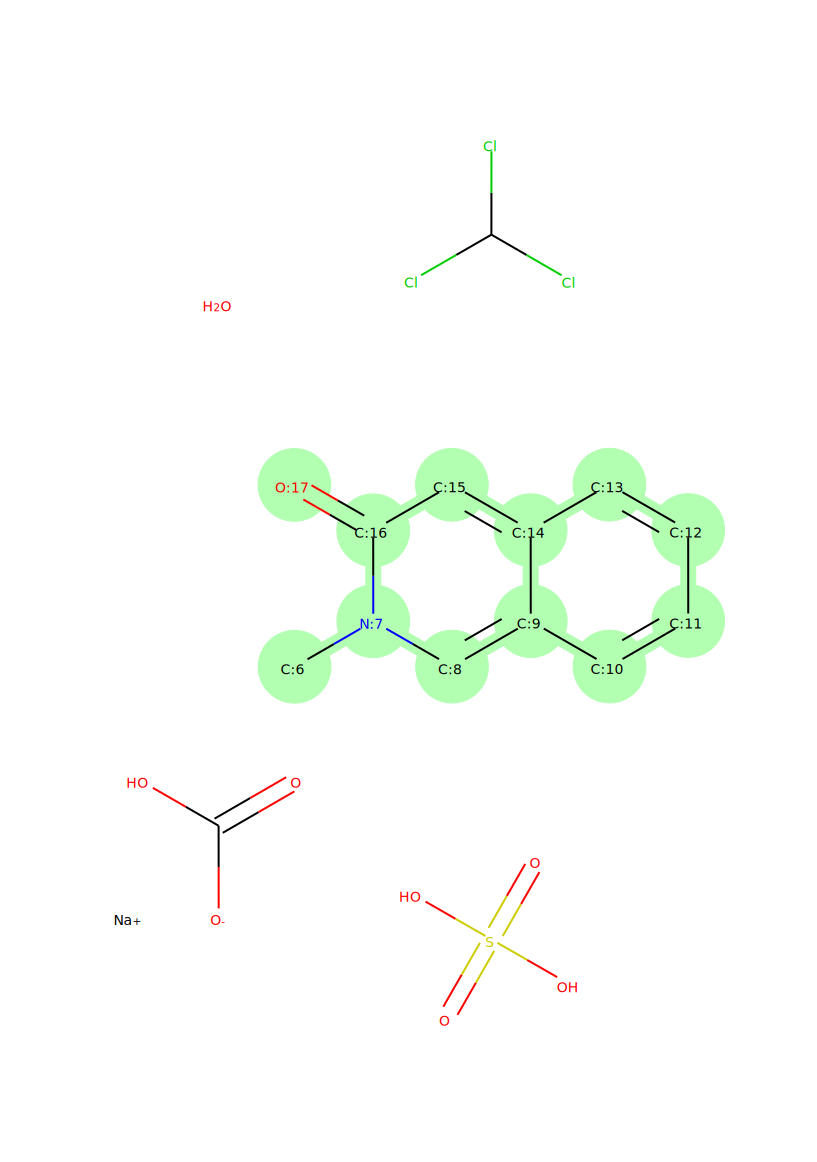

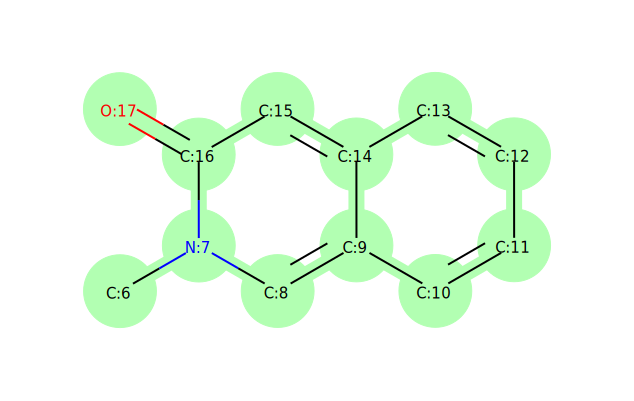

[CH:1]1[C:2](/[CH:8]=[N:9]/[NH:10][C:11]([NH:13]/[N:14]=[CH:15]/[C:16]2[CH:21]=[CH:20][C:19]([Cl:22])=[CH:18][CH:17]=2)=[NH:12])=[CH:3][CH:4]=[C:5]([Cl:7])[CH:6]=1.Cl.C(O)C(O)C>>[CH:17]1[C:16](/[CH:15]=[N:14]/[NH:13][C:11]([NH:10]/[N:9]=[CH:8]/[C:2]2[CH:3]=[CH:4][C:5]([Cl:7])=[CH:6][CH:1]=2)=[NH:12])=[CH:21][CH:20]=[C:19]([Cl:22])[CH:18]=1 


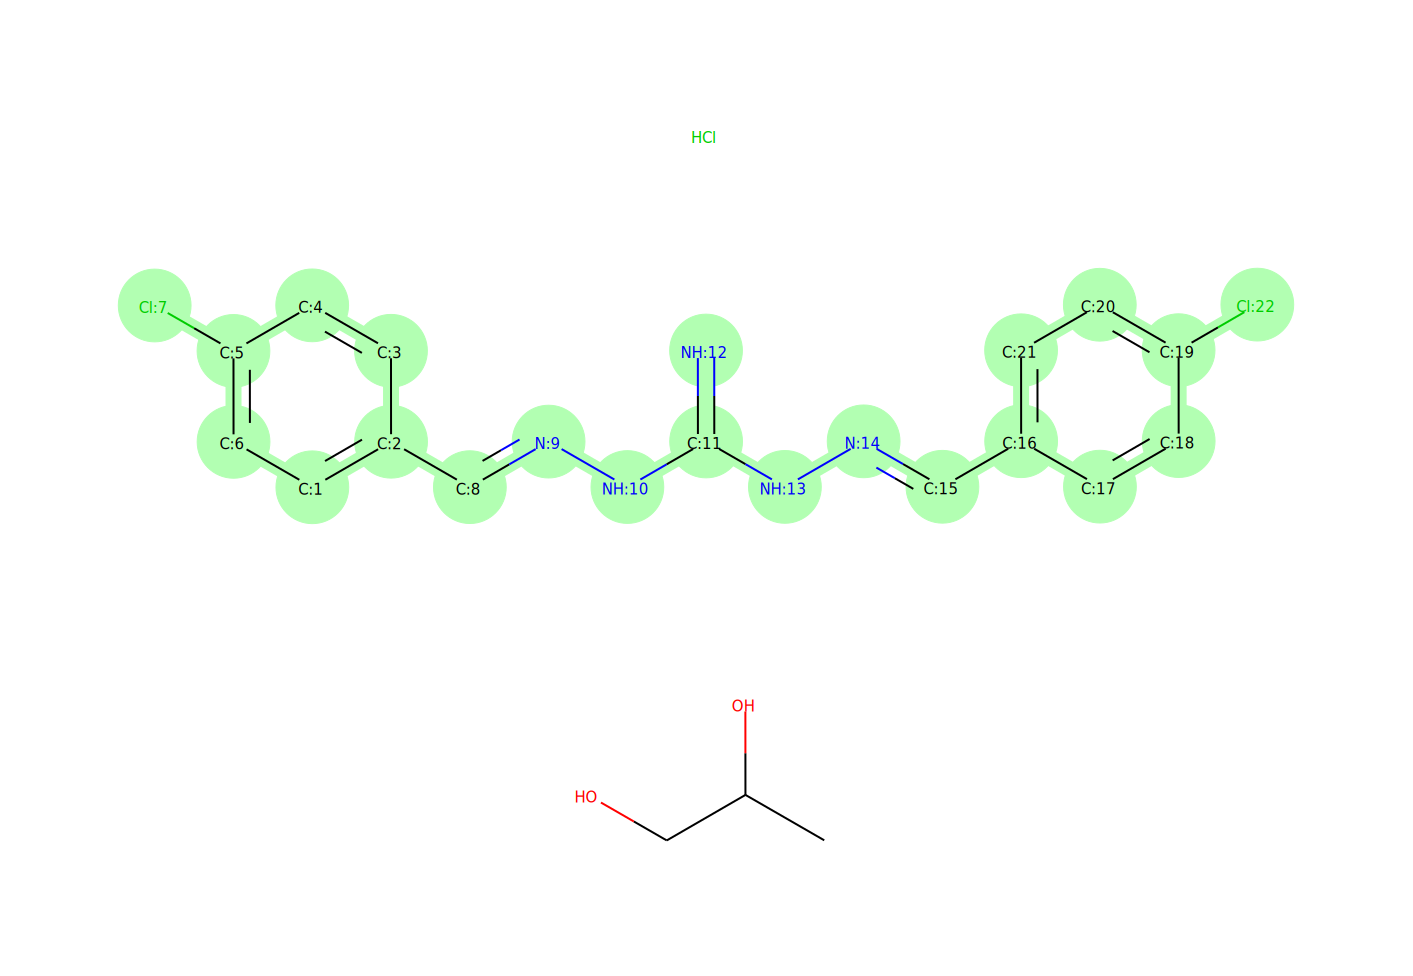

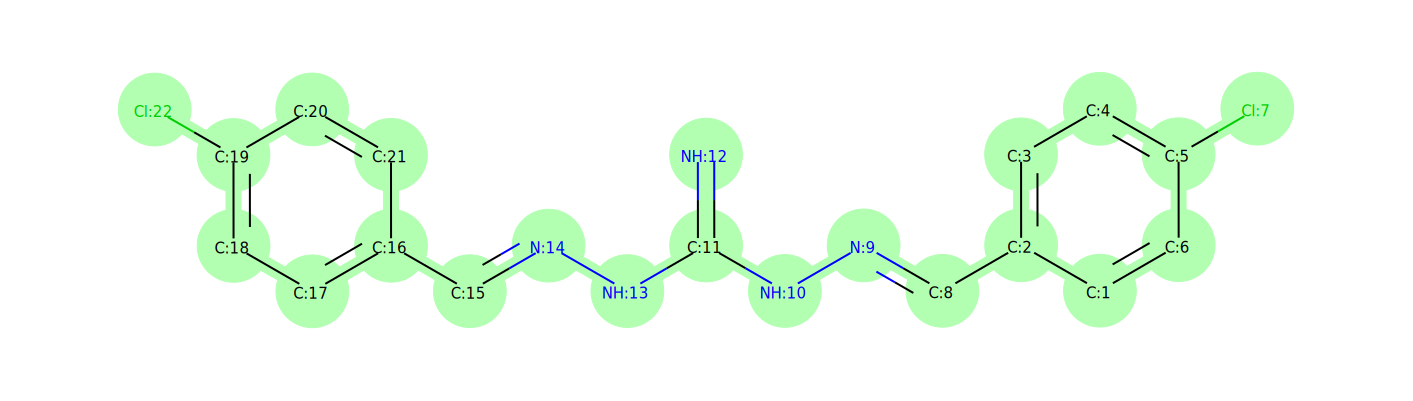

CN(C)C1CC2C3C(=CC(C)=CC=3C)NC=2CC1.[H-].[Na+].CI.Cl.[CH3:24][N:25]([CH3:42])[CH:26]1[CH2:38][C:37]2[C:36]3[C:31](=[CH:32][C:33]([CH3:40])=[CH:34][C:35]=3[CH3:39])[N:30]([CH3:41])[C:29]=2[CH2:28][CH2:27]1>CN(C)C=O>[CH3:42][N:25]([CH3:24])[CH:26]1[CH2:38][C:37]2[C:36]3[C:31](=[CH:32][C:33]([CH3:40])=[CH:34][C:35]=3[CH3:39])[N:30]([CH3:41])[C:29]=2[CH2:28][CH2:27]1 


RDKit WARNING: [18:49:19] WARNING: not removing hydrogen atom without neighbors


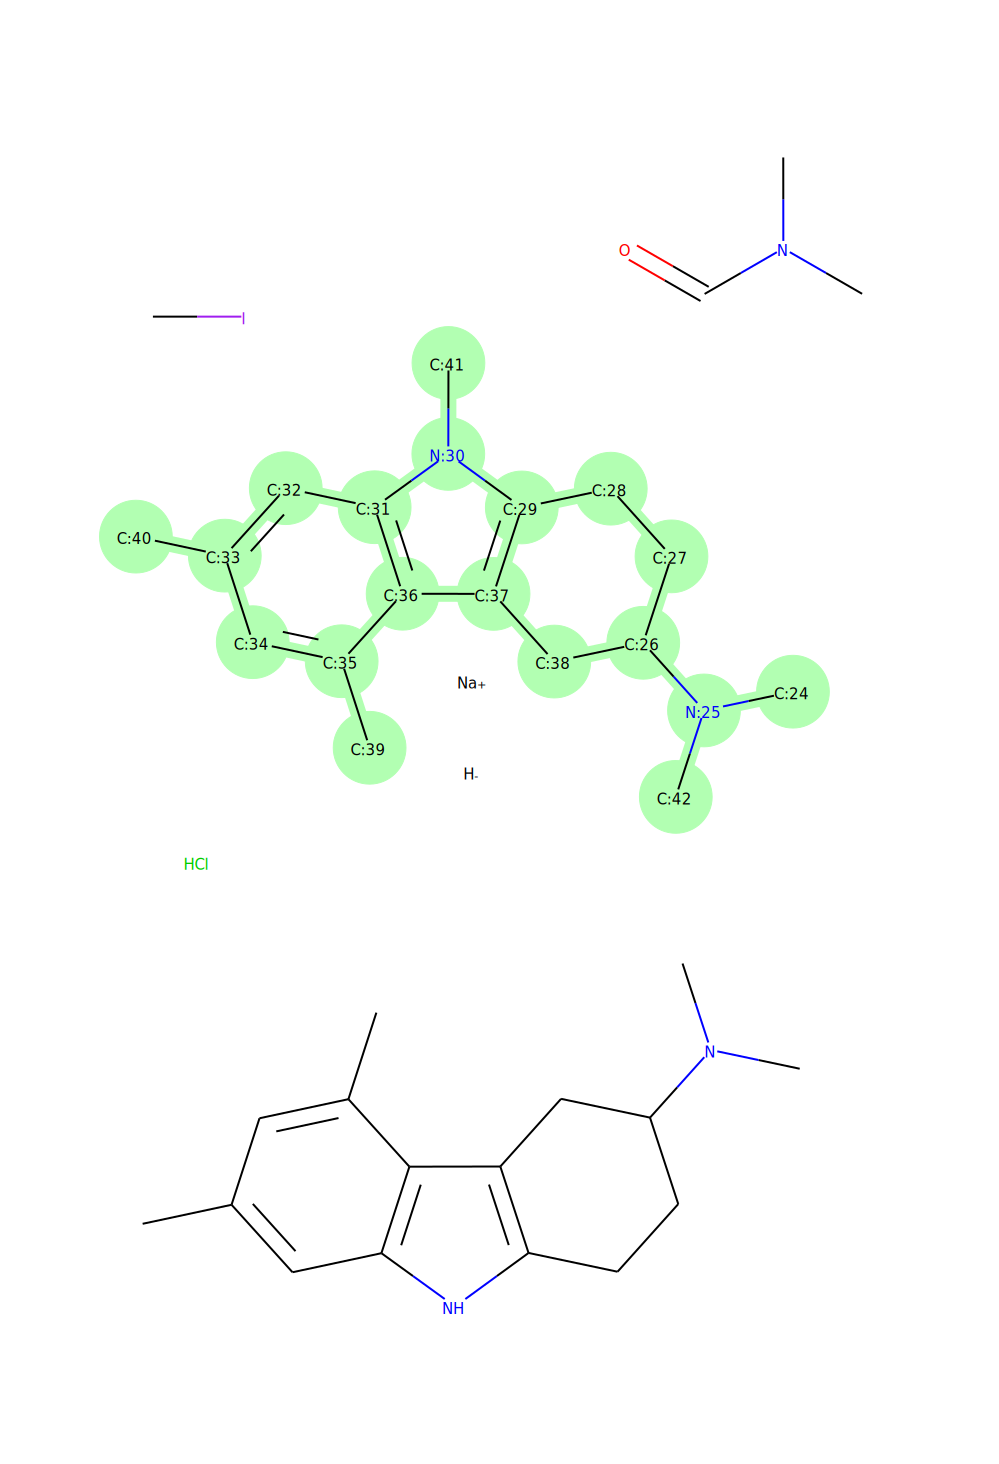

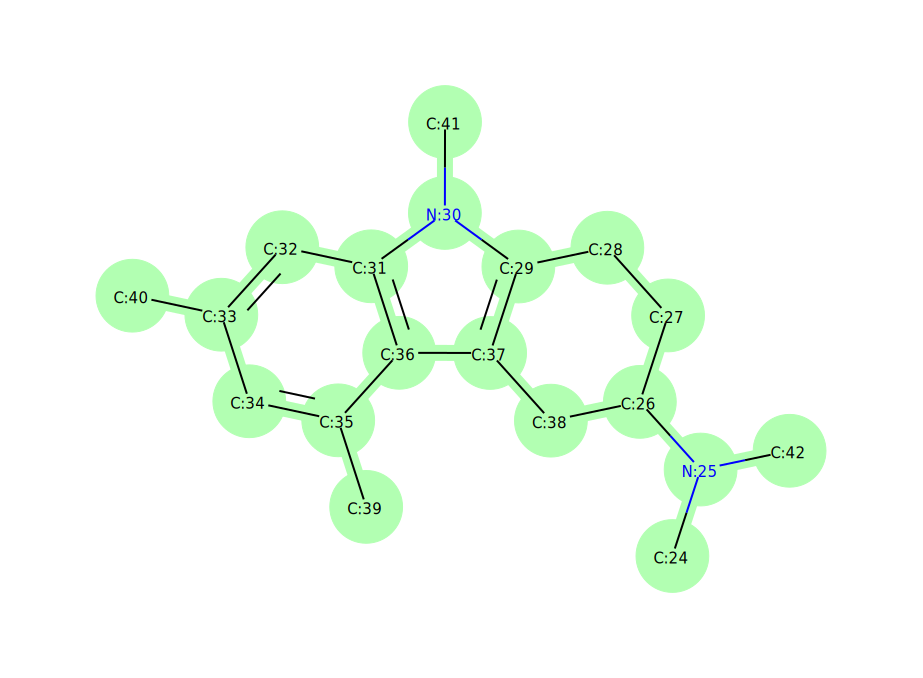

ClC1CNC(C2NC(=O)C(C3CCC(Cl)CN3)NC2=O)CC1.O.Cl.Cl.[OH:26][CH:27]1[CH2:32][NH:31][CH:30]([CH:33]2[NH:38][C:37](=[O:39])[CH:36]([CH:40]3[CH2:45][CH2:44][CH:43]([OH:46])[CH2:42][NH:41]3)[NH:35][C:34]2=[O:47])[CH2:29][CH2:28]1>CO>[OH:46][CH:43]1[CH2:42][NH:41][CH:40]([CH:36]2[NH:35][C:34](=[O:47])[CH:33]([CH:30]3[CH2:29][CH2:28][CH:27]([OH:26])[CH2:32][NH:31]3)[NH:38][C:37]2=[O:39])[CH2:45][CH2:44]1 


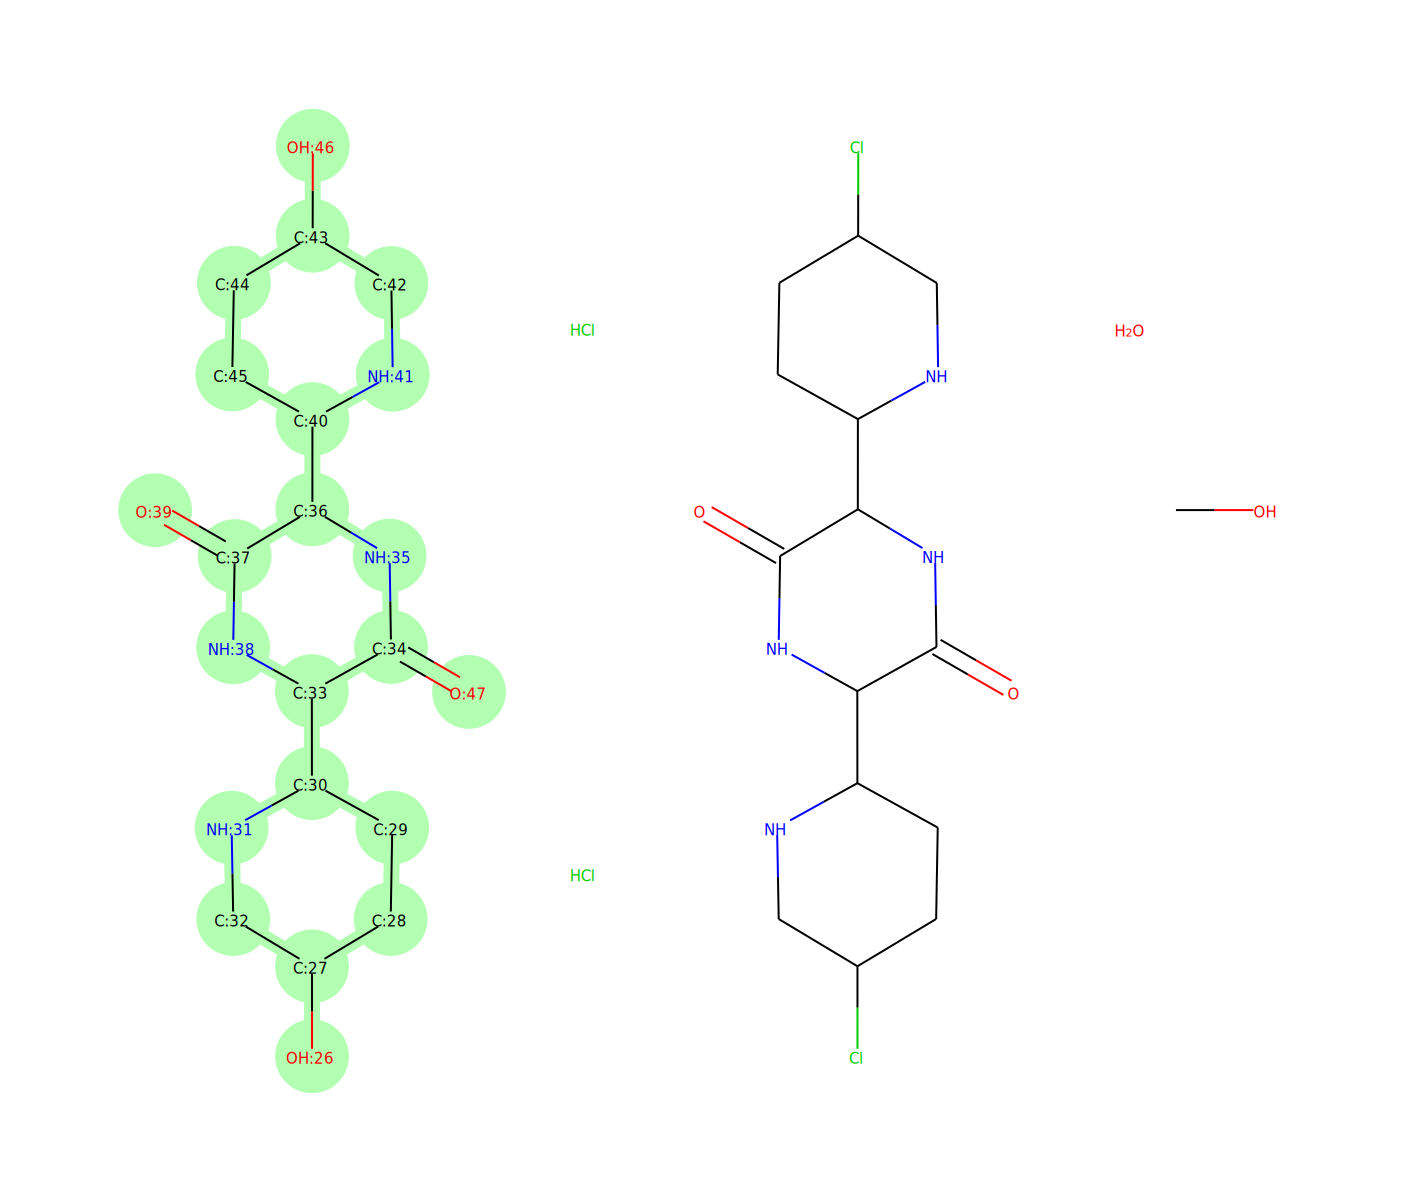

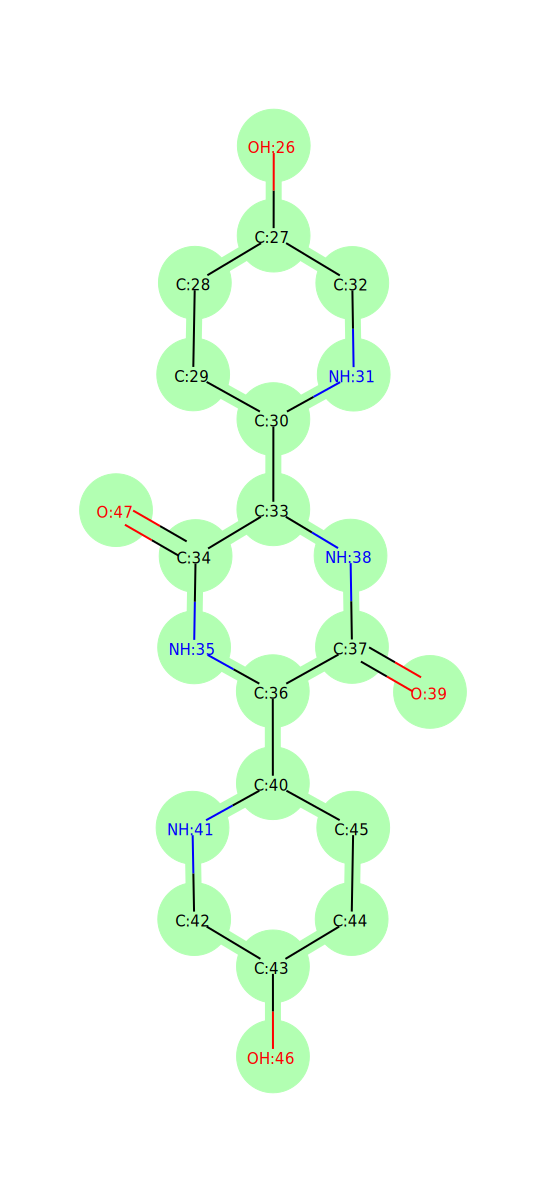

NC1C=CN=C(C2C=CC=CN=2)N=1.C(OC=C(C(OCC)=O)C(OCC)=O)C.CS(O)(=O)=O.[N:34]1[CH:39]=[CH:38][CH:37]=[CH:36][C:35]=1[C:40]1[N:45]=[C:44]([NH:46][CH:47]=[C:48]([C:54]([O:56][CH2:57][CH3:58])=[O:55])[C:49]([O:51][CH2:52][CH3:53])=[O:50])[CH:43]=[CH:42][N:41]=1>>[N:34]1[CH:39]=[CH:38][CH:37]=[CH:36][C:35]=1[C:40]1[N:45]=[C:44]([NH:46][CH:47]=[C:48]([C:54]([O:56][CH2:57][CH3:58])=[O:55])[C:49]([O:51][CH2:52][CH3:53])=[O:50])[CH:43]=[CH:42][N:41]=1 


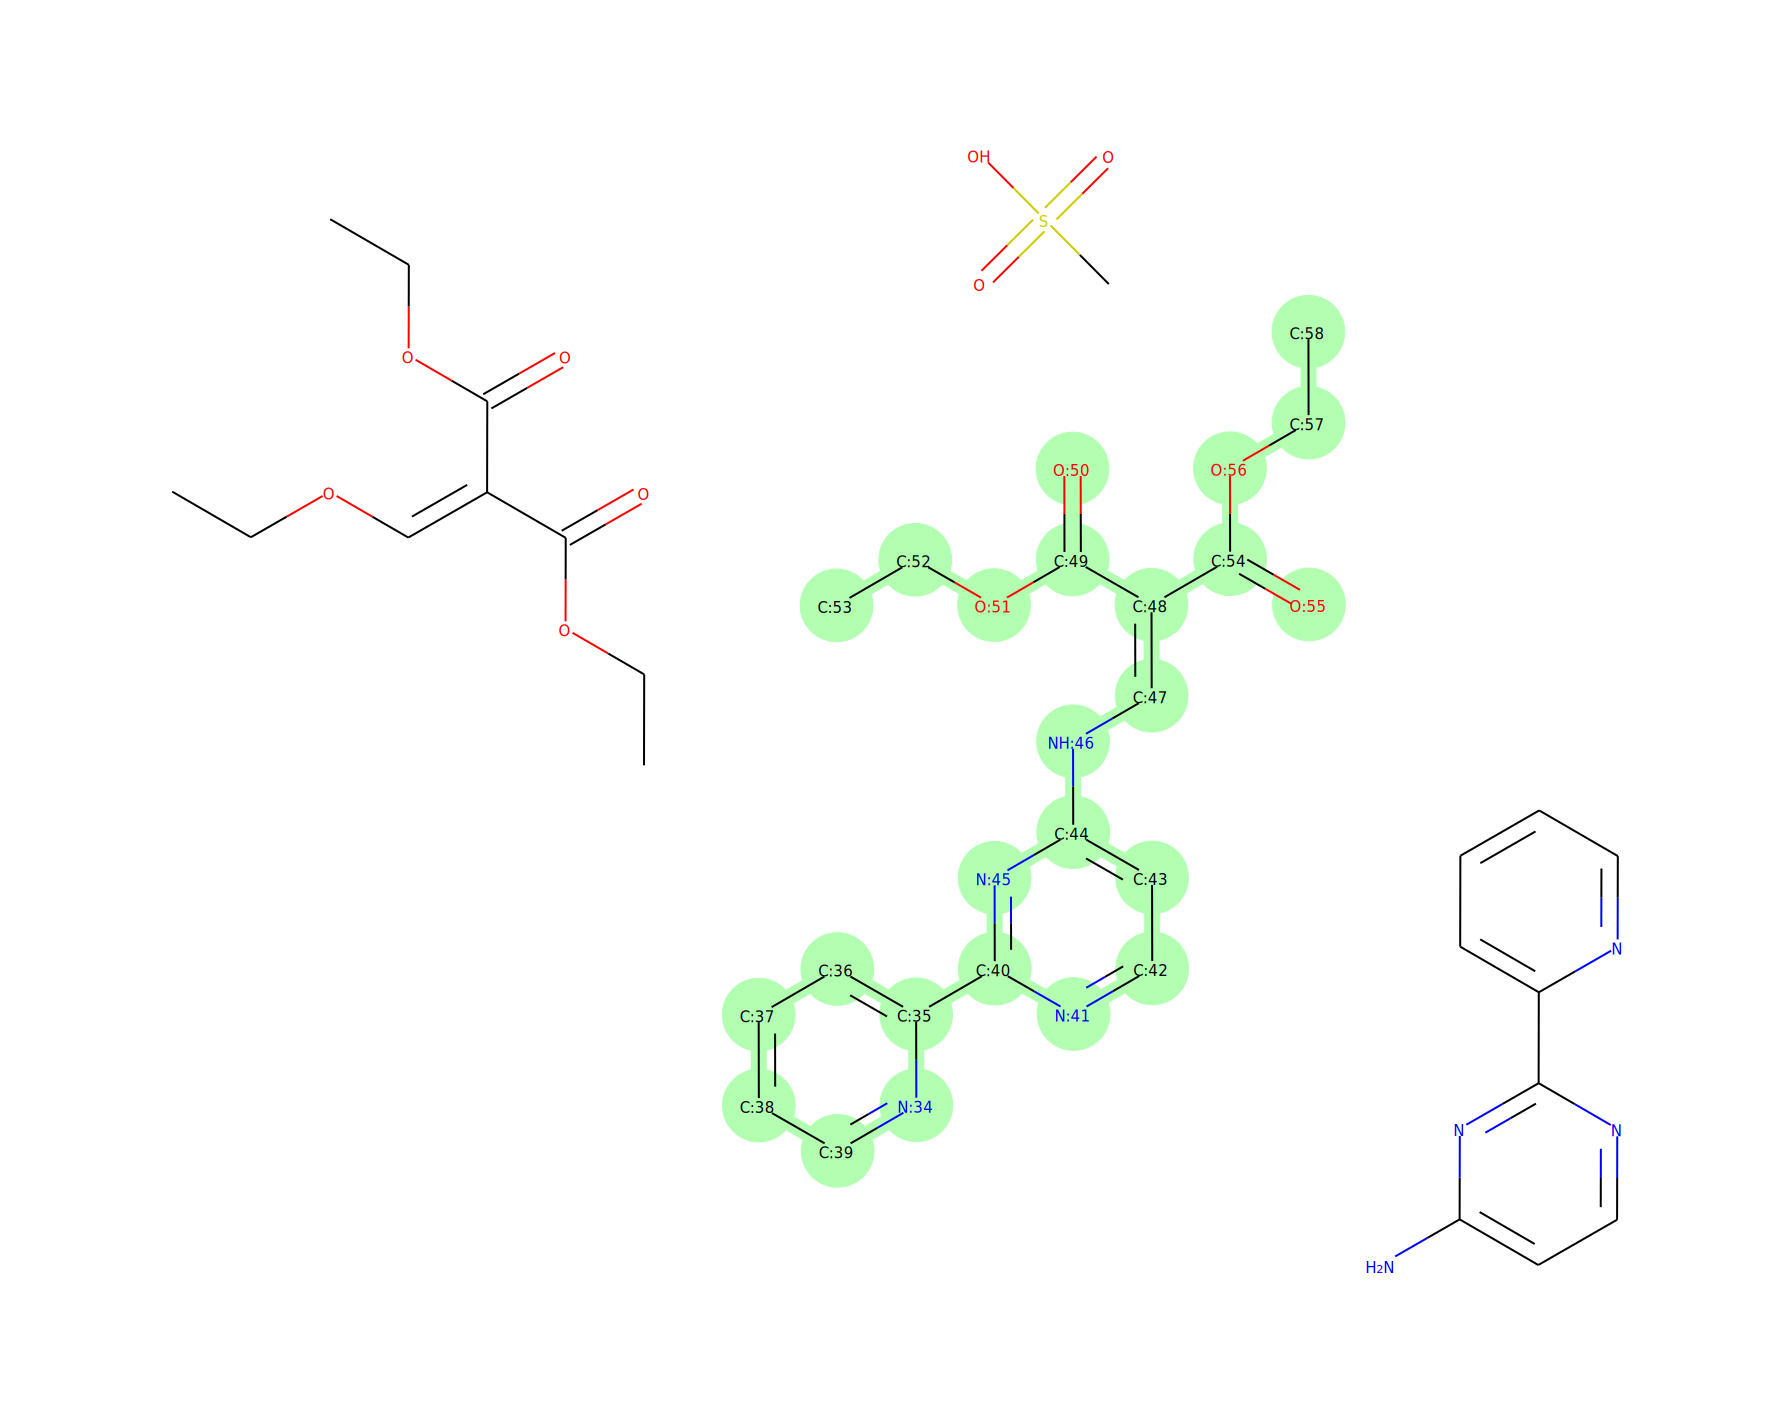

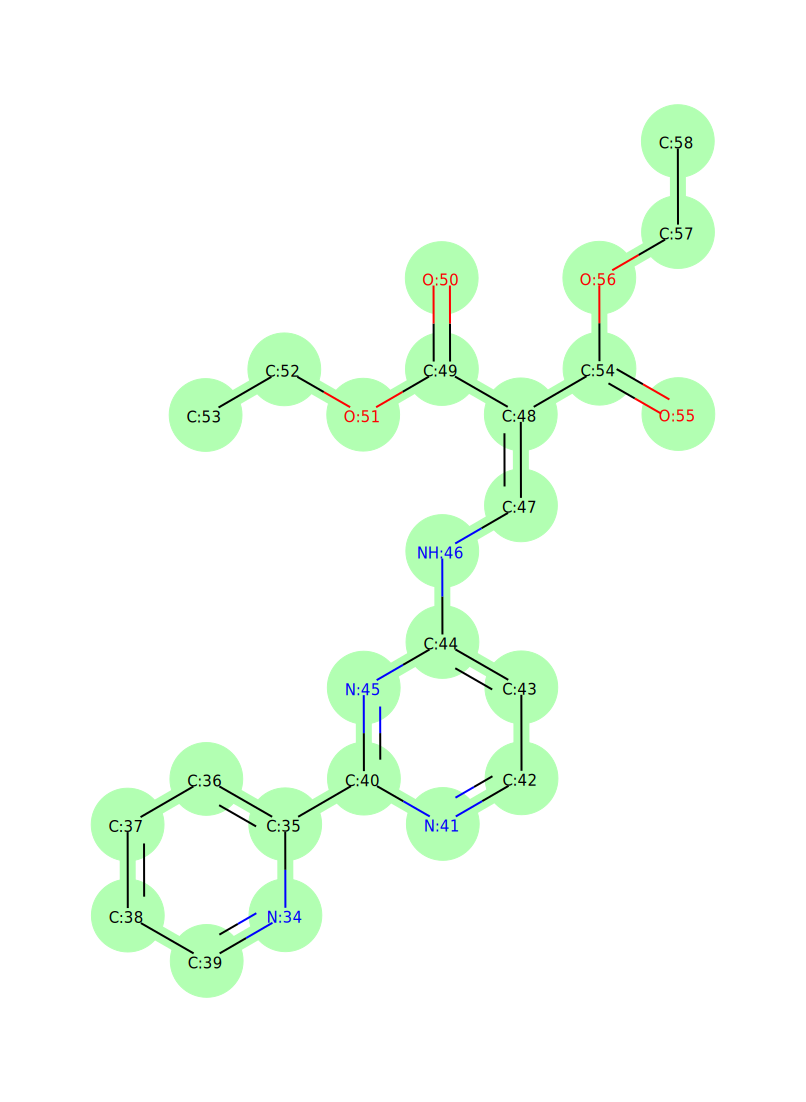

Cl.[Cl:2][C:3]1[CH:8]=[CH:7][C:6]([NH:9][NH2:10])=[C:5]([F:11])[CH:4]=1.[OH-].[Na+]>C(Cl)Cl>[Cl:2][C:3]1[CH:8]=[CH:7][C:6]([NH:9][NH2:10])=[C:5]([F:11])[CH:4]=1 


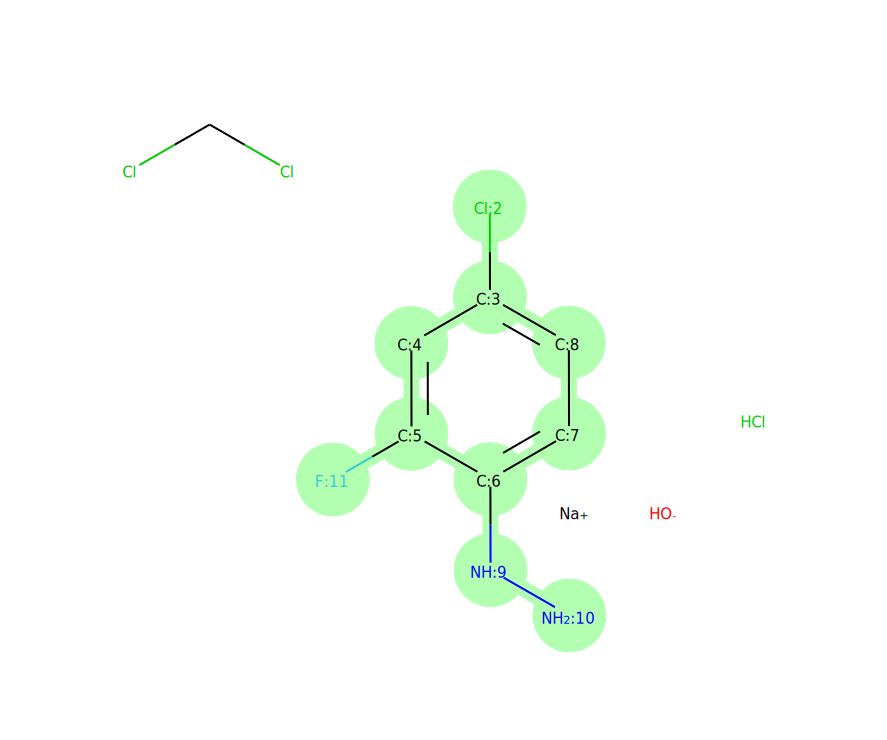

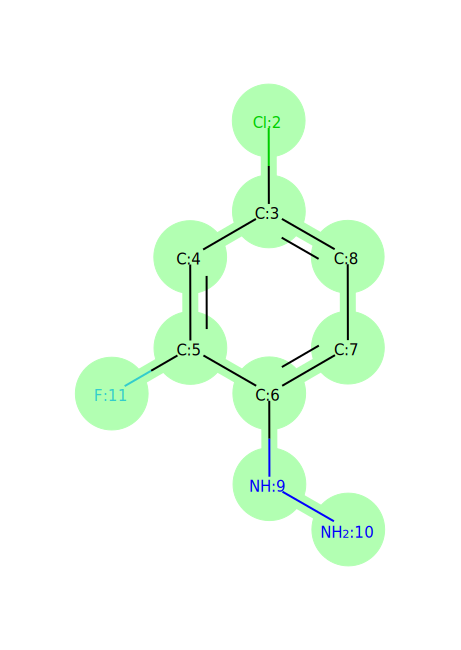

C(O)(=O)CC.C(O)(=O)CC.[OH:11][C@@H:12]1[CH2:17][CH2:16][C@H:15]2[C@H:18]3[C@H:29]([CH2:30][CH2:31][C@:13]12[CH3:14])[C@:26]1([CH2:27][OH:28])[C:21](=[CH:22][C:23](=[O:33])[CH2:24][C@@H:25]1[CH3:32])[CH2:20][CH2:19]3.C(=O)([O-])[O-].[Na+].[Na+]>CO>[OH:11][C@H:12]1[CH2:17][CH2:16][C@H:15]2[C@H:18]3[C@H:29]([CH2:30][CH2:31][C@:13]12[CH3:14])[C@:26]1([CH2:27][OH:28])[C:21](=[CH:22][C:23](=[O:33])[CH2:24][C@@H:25]1[CH3:32])[CH2:20][CH2:19]3 


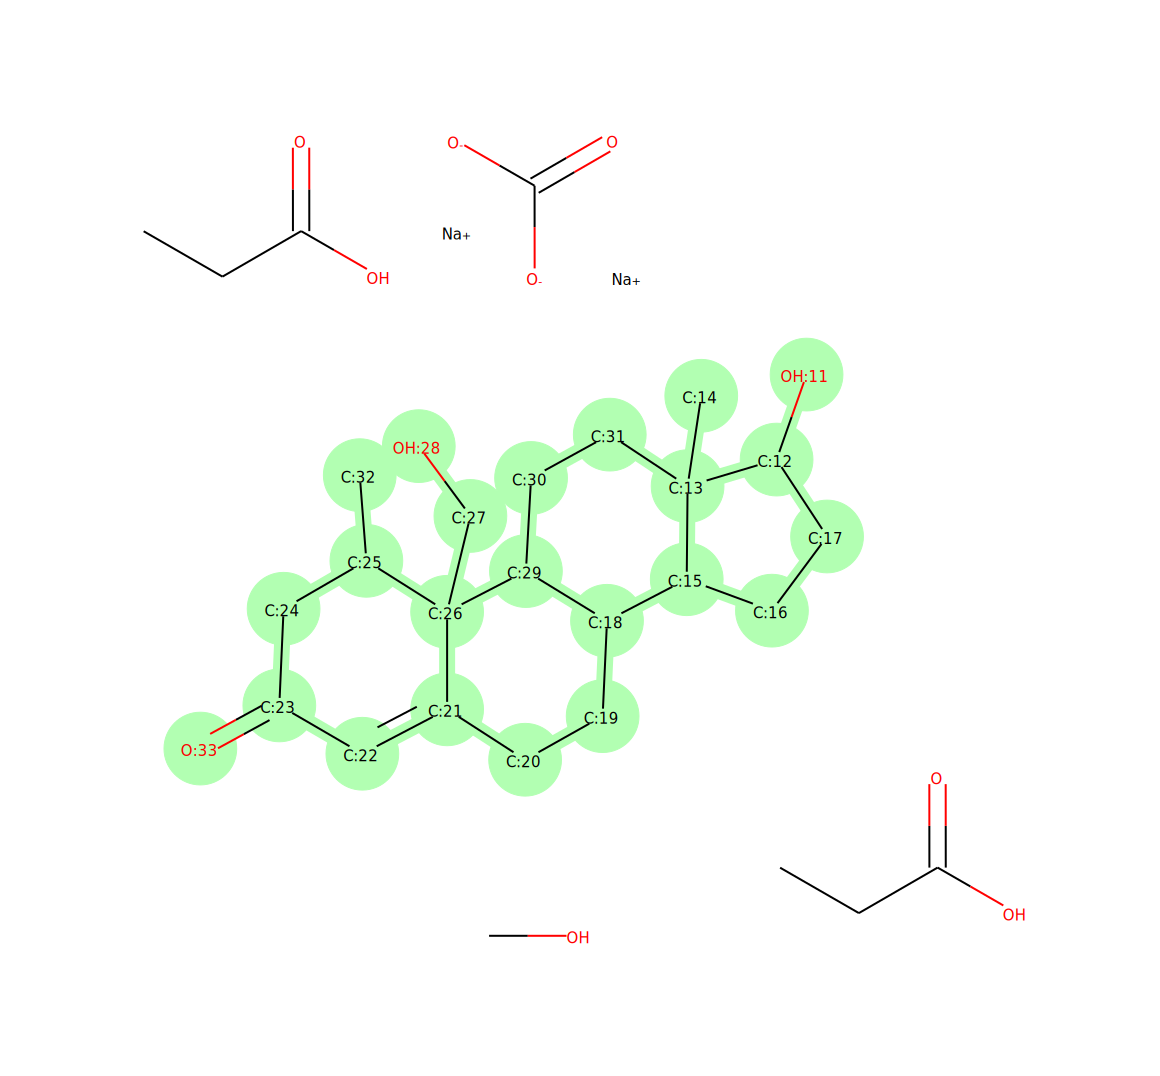

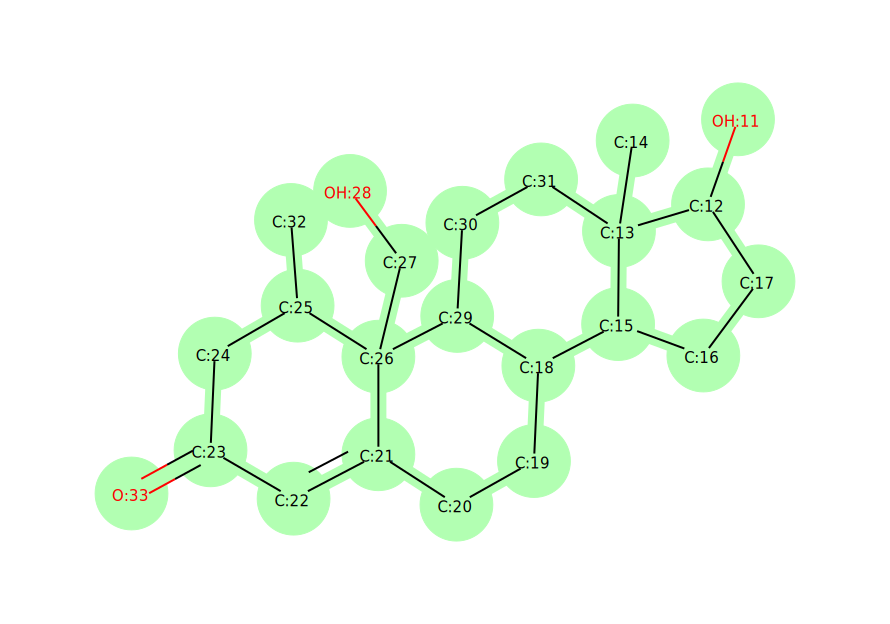

Br.[Cl:2][C:3]1[CH:8]=[CH:7][C:6]([C:9]2([OH:17])[CH2:13][S:12][C:11]3=[N:14][CH2:15][CH2:16][N:10]23)=[CH:5][C:4]=1[S:18](=[O:23])(=[O:22])[N:19]([CH3:21])[CH3:20].C(=O)(O)[O-].[Na+]>O>[Cl:2][C:3]1[CH:8]=[CH:7][C:6]([C:9]2([OH:17])[CH2:13][S:12][C:11]3=[N:14][CH2:15][CH2:16][N:10]23)=[CH:5][C:4]=1[S:18](=[O:23])(=[O:22])[N:19]([CH3:20])[CH3:21] 


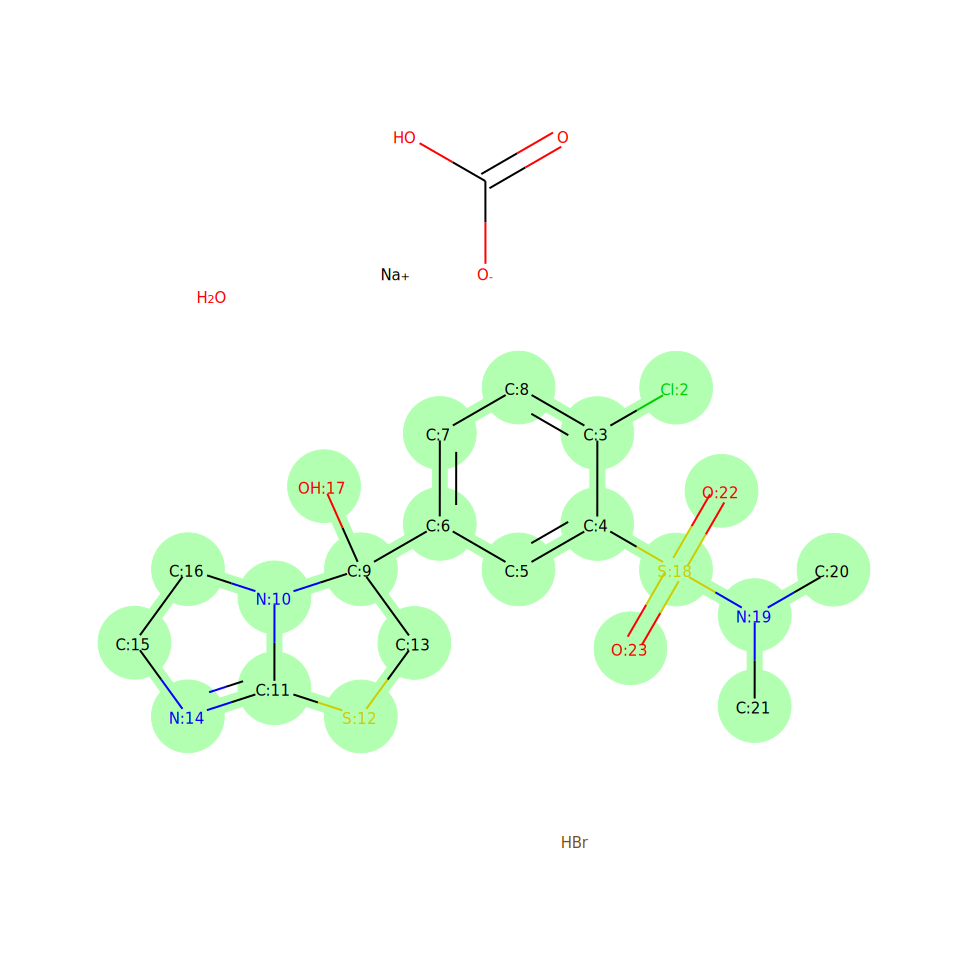

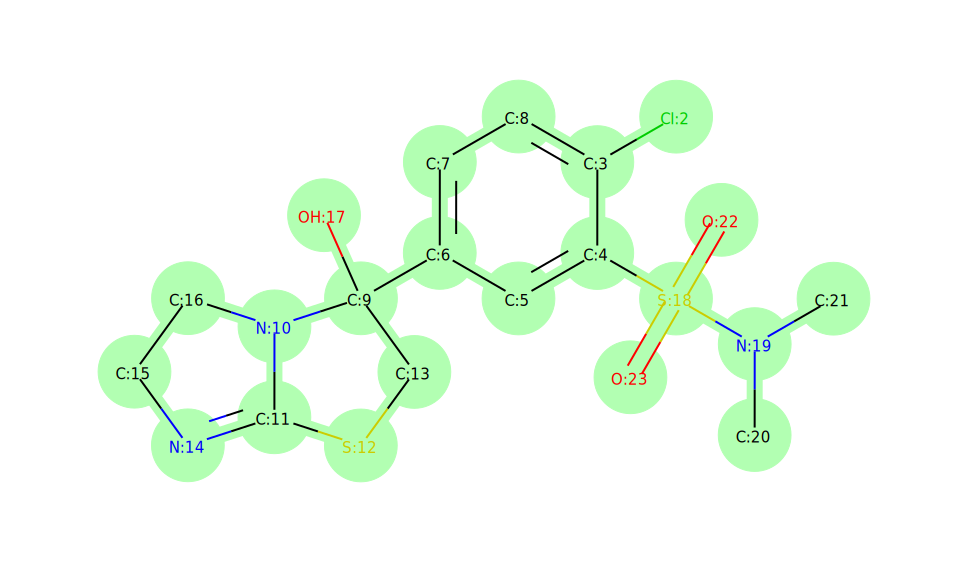

[CH2:1]([OH:10])[C@H:2]([C@H:4]([C@@H:6]([CH2:8][OH:9])[OH:7])[OH:5])[OH:3].C(O)[C@@H]([C@@H](CO)O)O.C(O)[C@H]([C@@H](CO)O)O.OCC(O)CCC(O)CO>>[CH2:1]([OH:10])[C@@H:2]([C@H:4]([C@@H:6]([CH2:8][OH:9])[OH:7])[OH:5])[OH:3]


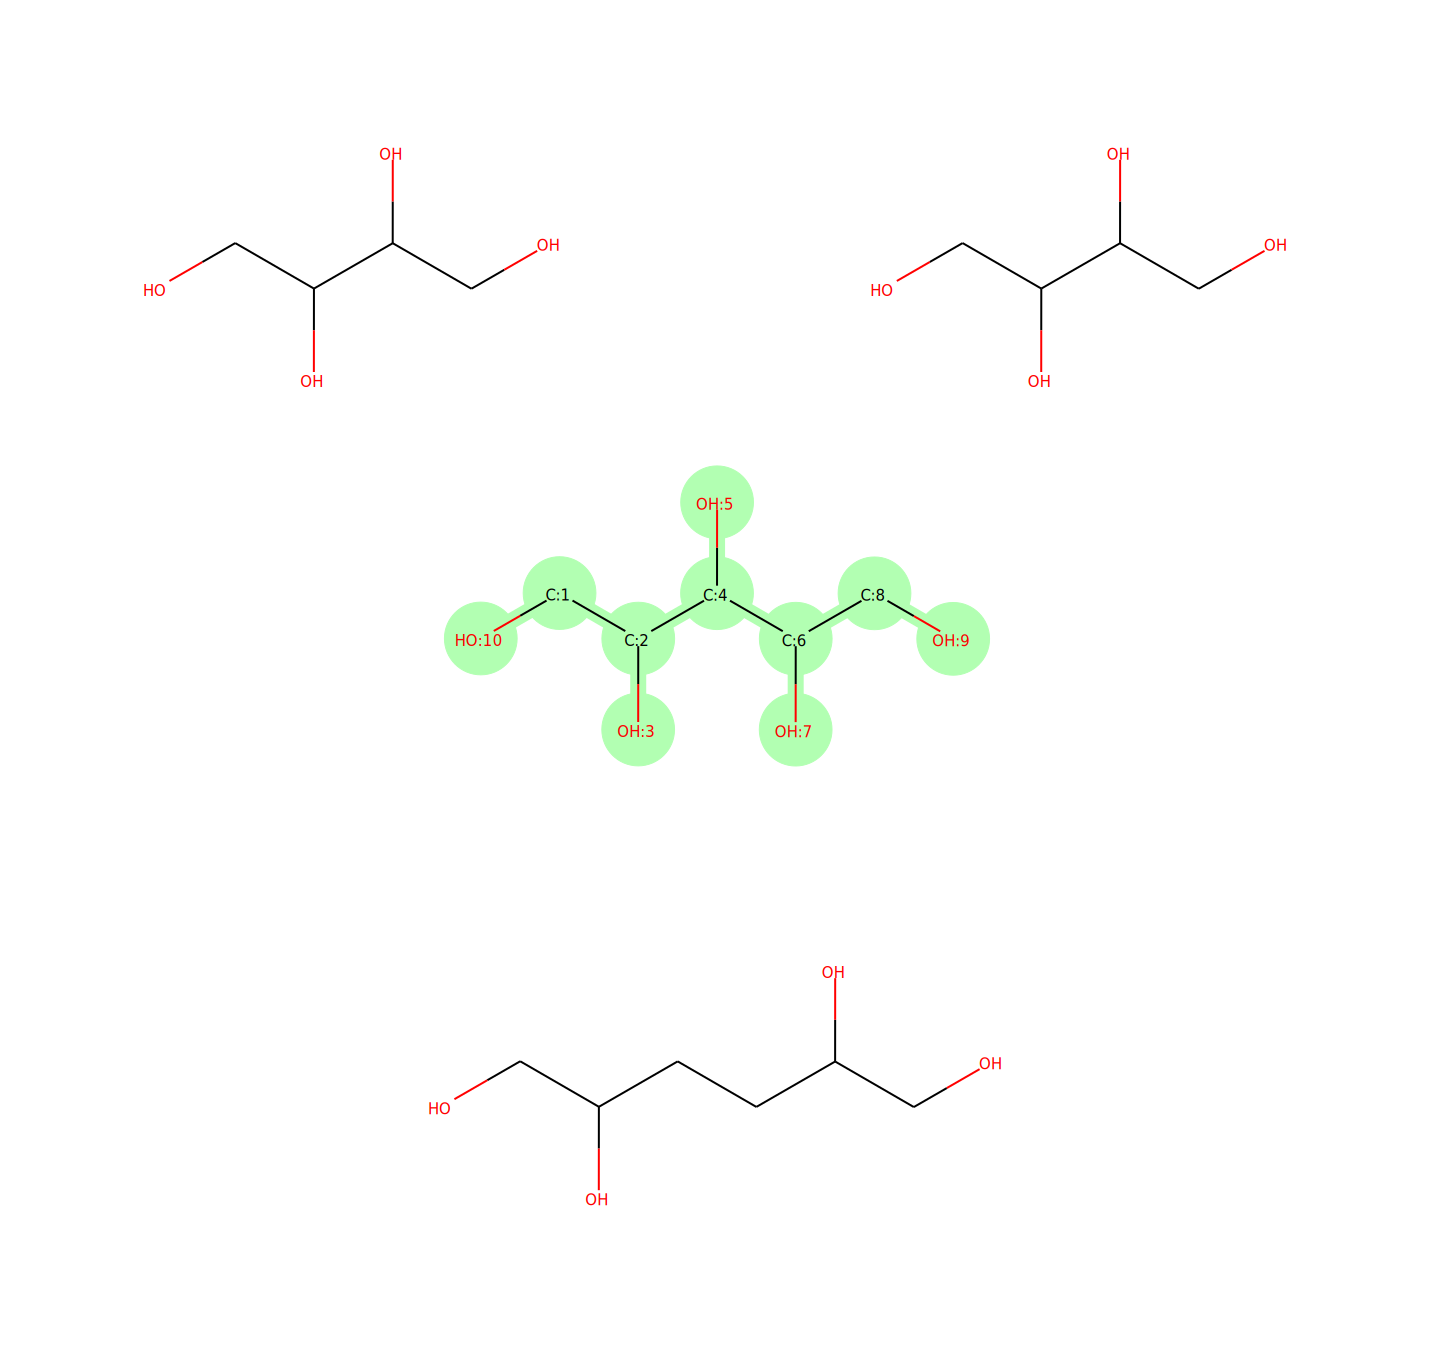

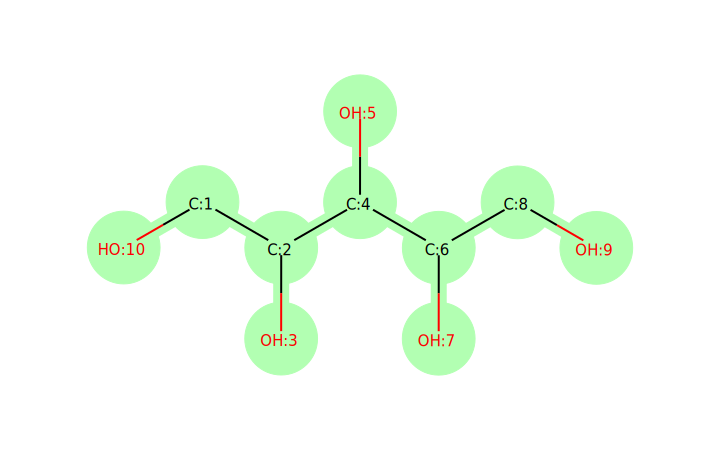

In [32]:
n = 0
for i, idx in enumerate(idxs):
    data = test_dataset[idx]
    tar = data["target_center"]
    if len(tar[tar == 1]) == 0:
        print(data['smarts'])
        r, p = draw_gt_reaction(data, mapping=True)
        display(SVG(p))
        display(SVG(r))
        if n < 10:
            n += 1 
        else: 
            break

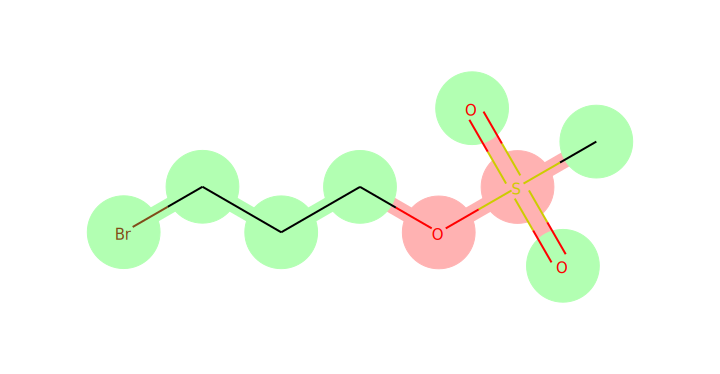

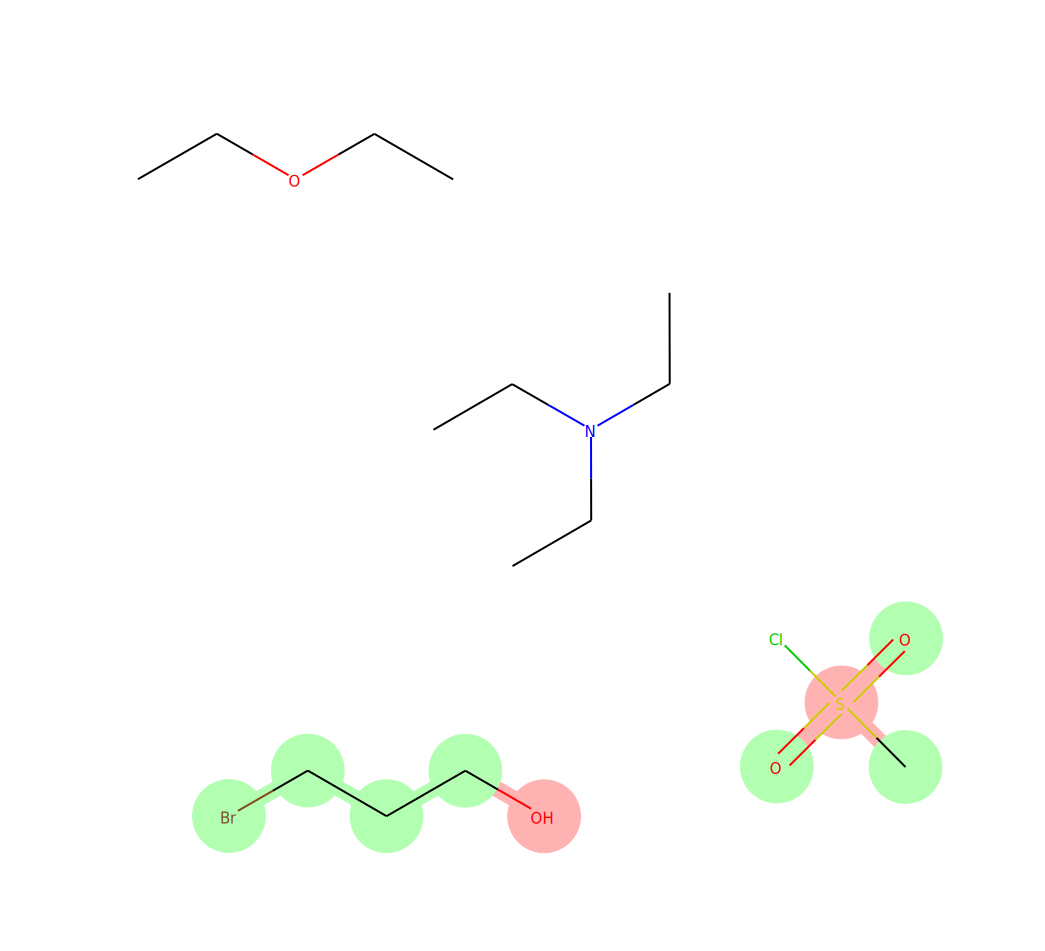

In [49]:
data = test_dataset[0]
p, r = draw_gt_reaction(data)
display(SVG(p))
display(SVG(r))